# Setup

In [25]:
import numpy as np
import pandas as pd
from one.api import ONE
from psyfun import io
from psyfun.config import *
from psyfun import plots
import matplotlib as pl
from matplotlib import pyplot as plt

one = ONE()

# only run if first-time setup
# Fetching all session, insertion, and spike data
# DAVIDE: for some reason, fetching keeps getting interrupted by the absence of certain files/directories.
#%run -i fetchdata.py -a

# Load session and insertion metadata
df_sessions = pd.read_parquet(paths['sessions'])
df_insertions = pd.read_parquet(paths['insertions'])

# dropping na (PCA_DC)
df_sessions = df_sessions.query('n_tasks >= 2').dropna(subset=['task00_spontaneous_start', 'task01_spontaneous_start'])

# Create a DataFrame with eids (all sessions with a left vid), categorized by experimental group
eids_exp = df_sessions.loc[(df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True) & (df_sessions['control_recording'] == False), 'eid']
eids_cont = df_sessions.loc[(df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True) & (df_sessions['control_recording'] == True), 'eid']



### setup experimental

In [26]:
# Import dataframe with PCA results entries (eid, epoch_name, filepath)
exp_results = pd.read_csv(r'C:\Users\marti\Documents\mainen\psychedelics\video\exp_results')

# Correct the epoch_name for easier access (otherwise interval stamps mess up possible grouping)
# Assumes consecutive loading (each eid, 6 sorted epochs)
epoch_naming = ['pre_spo', 'pre_rfm', 'pre_rep', 'post_spo', 'post_rfm', 'post_rep']

for eid, group in exp_results.groupby('eid'):
    idx = group.index
    if len(idx) == len(epoch_naming):
        exp_results.loc[idx, 'epoch'] = epoch_naming
    else:
        print(f"Warning: eid {eid} has {len(idx)} entries, expected {len(epoch_naming)}")

### setup control

In [27]:
# Import dataframe with PCA results entries (eid, epoch_name, filepath)
cont_results = pd.read_csv(r'C:\Users\marti\Documents\mainen\psychedelics\video\cont_results')

# Correct the epoch_name for easier access (otherwise interval stamps mess up possible grouping)
# Assumes consecutive loading (each eid, 6 sorted epochs)
epoch_naming = ['pre_spo', 'pre_rfm', 'pre_rep', 'post_spo', 'post_rfm', 'post_rep']

for eid, group in cont_results.groupby('eid'):
    idx = group.index
    if len(idx) == len(epoch_naming):
        cont_results.loc[idx, 'epoch'] = epoch_naming
    else:
        print(f"Warning: eid {eid} has {len(idx)} entries, expected {len(epoch_naming)}")

### functions

In [28]:
LSD_CONT_palette =  ['mediumorchid','mediumseagreen']

In [30]:
import os
import numpy as np
import pandas as pd

def download_video(eid, camera = "left"):
    """
    Downloads raw video data from specific session. Camera parameter can be switched to "body" and "right".
    
    Parameters
    ----------
    eid (str): Experiment/session identifier

    camera (str): Camera orientation identifier (left by default). "body", "right" are other available options.

    Returns
    -------
    video_path: Local path for saved video
    """
    
    if camera == "left":
        video_path = one.load_dataset(eid, f'*leftCamera.raw*', collection='raw_video_data')
    elif camera == "right":
        video_path = one.load_dataset(eid, f'*rightCamera.raw*', collection='raw_video_data')
    elif camera == "body":
        video_path = one.load_dataset(eid, f'*bodyCamera.raw*', collection='raw_video_data')
    else:
         raise ValueError(f"Unknown camera parameter: {camera}")

    return video_path

def get_time_epochs(df_sessions, eid):

    video_data = df_sessions.loc[df_sessions['eid'] == eid]
    
    # epochs
    epoch_pre = [
        ("task00_spontaneous", video_data['task00_spontaneous_start'].values[0], video_data['task00_spontaneous_stop'].values[0]),
        ("task00_rfm", video_data['task00_rfm_start'].values[0], video_data['task00_rfm_stop'].values[0]),
        ("task00_replay", video_data['task00_replay_start'].values[0], video_data['task00_replay_stop'].values[0])
    ]

    epoch_post = [
        ("task01_spontaneous", video_data['task01_spontaneous_start'].values[0], video_data['task01_spontaneous_stop'].values[0]),
        ("task01_rfm", video_data['task01_rfm_start'].values[0], video_data['task01_rfm_stop'].values[0]),
        ("task01_replay", video_data['task01_replay_start'].values[0], video_data['task01_replay_stop'].values[0])
    ]

    return epoch_pre, epoch_post


# will be useful for multi-video analysis at the end
def load_pca_results(results, eid, epoch_name):
    """
    Imports MotionMap results on motion energy video analysis. Obtains path for .npy file based on eid, loads, and returns the data
    in a dataframe.

    Parameters
    ----------
    results: pd.DataFrame
        Dataframe containing PCA results containing eid, epoch_name, savename
    eid: str
        Experiment/session identifier.
    epoch_name: str
        Epoch identifier. Can take the values of 'spontaneous','rfm', or 'replay'

    Returns
    -------
    pre, post: pd. Dataframe
        MotionMap results for pre/post particular epochs.
    """
        

    path_df = results[results['eid'] == eid]

    if epoch_name == 'spontaneous':
        pre = np.load(path_df[path_df['epoch'] == 'pre_spo']['savename'].values[0], allow_pickle=True).item()
        post = np.load(path_df[path_df['epoch'] == 'post_spo']['savename'].values[0], allow_pickle=True).item()

    elif epoch_name == 'rfm':
        pre = np.load(path_df[path_df['epoch'] == 'pre_rfm']['savename'].values[0], allow_pickle=True).item()
        post = np.load(path_df[path_df['epoch'] == 'post_rfm']['savename'].values[0], allow_pickle=True).item()

    elif epoch_name == 'replay':
        pre = np.load(path_df[path_df['epoch'] == 'pre_rep']['savename'].values[0], allow_pickle=True).item()
        post = np.load(path_df[path_df['epoch'] == 'post_rep']['savename'].values[0], allow_pickle=True).item()

    else:
        raise NameError(f"Epoch name not recognized {epoch_name}")
    return pre, post

# temporal_pca: shape (n_components, n_frames)
# Binarize each component time series and compute LZC

import antropy as ant
def compute_lz_entropy(temporal_pca, threshold='median', n_comps = 500):
    """
    Computes the Lempel-Ziv entropy of an eigenmask frame projection.
    Each row tells how much that PC (row-indexed) was present in a particular frame.
    The algorithm binarizes by a given threshold (1 if PC was sufficiently present, 0 otherwise),
    and uses the resulting binary string to calculate the Zempel-Ziv entropy.

    Zempel-Ziv measures the richness of patterns found in a binary string. In our case, the metric is
    a proxy for the frequency and complexity  of motif appearance across the video.
    
    Parameters
    ----------
    temporal_pca: np.array
        Array of shape (n_components, n_frames) containing the embeddings of eigenmasks onto the video.
    threshold: string
        Determines the threshold method to binarize. If not median, then a number (float) must be given.
    n_comps: int
        Number of components to keep. >150 explains at least 80% of variance in all sessions.

    Returns
    -------
    lz_scores: np.array
        Array of shape (n_comps,) with the corresponding LZ entropy for each Principal Component (eigenmask)
    """
    lz_scores = []
    
    for comp in temporal_pca[:k,]:
        if threshold == 'median':
            binary = (comp > np.median(comp)).astype(int)
        else:
            binary = (comp > threshold).astype(int)
        lz = ant.lziv_complexity(binary, normalize=True)
        lz_scores.append(lz)
    return np.array(lz_scores)

from sklearn.metrics.pairwise import cosine_similarity
from psyfun import util

def extract_measure(exp_results, cont_results, metric, n_comps = 500):
    """
    Helper function to optimize metric extraction from MotionMap results.

    Parameters
    ---------

    exp_results, cont_results: dict
        Dictionaries with eid and paths for individual session's results.
    metric: string
        Metric to be extracted. Method only supports 'similarity' (cosine similarity on eigenmasks),
        'entropy' (Lempel-Ziv entropy on temporal proj.), and 'powerlaw' (power law variance slope).
    n_comps: int
        Number of components to keep in the analysis. >150 explains at least 80% variance in all sessions.

    Results
    -------
    all_data: pd.DataFrame
        Dataframe with all results. Columns include eid (experimental id), epoch (Passive Protocol Epoch),
        time (pre/post), condition (LSD/Saline), and the metric value.
    """

    assert metric == 'similarity' or metric == 'entropy' or metric == 'powerlaw'

    k = n_comps # <-- components to keep

    experimental = []
    for eid in exp_results['eid'].unique():
        for epoch in ['spontaneous', 'rfm', 'replay']:

            pre, post = load_pca_results(exp_results, eid, epoch_name=epoch)

            pre_eigenmsk, pre_temp, pre_eigenval = get_eigen(pre)
            post_eigenmsk, post_temp, post_eigenval = get_eigen(post)

            # metric computation
            if metric == 'entropy':
                # traspose for functionality
                pre_temp = pre_temp.T
                post_temp = post_temp.T

                metric_pre = compute_lz_entropy(pre_temp,k)
                metric_post = compute_lz_entropy(post_temp,k)

                experimental.append((eid, epoch, metric_pre, 'pre'))
                experimental.append((eid, epoch, metric_post, 'post'))
            
            elif metric == 'powerlaw':
                metric_pre = util.power_law_slope(pre_eigenval,k)
                metric_post = util.power_law_slope(post_eigenval,k)

                experimental.append((eid, epoch, metric_pre, 'pre'))
                experimental.append((eid, epoch, metric_post, 'post'))

            elif metric == 'similarity':
                similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)

                max_similarity = np.max(np.abs(similarity_matrix), axis = 0)
                experimental.append((eid, epoch, np.mean(max_similarity)))
                

    ## control case
    control = []
    for eid in cont_results['eid'].unique():
        for epoch in ['spontaneous', 'rfm', 'replay']:
            pre, post = load_pca_results(cont_results, eid, epoch_name=epoch)

            pre_eigenmsk, pre_temp, pre_eigenval = get_eigen(pre)
            post_eigenmsk, post_temp, post_eigenval = get_eigen(post)

            # metric computation
            if metric == 'entropy':
                # traspose for functionality
                pre_temp = pre_temp.T
                post_temp = post_temp.T

                metric_pre = compute_lz_entropy(pre_temp,k)
                metric_post = compute_lz_entropy(post_temp,k)

                control.append((eid, epoch, metric_pre, 'pre'))
                control.append((eid, epoch, metric_post, 'post'))
            
            elif metric == 'powerlaw':
                metric_pre = util.power_law_slope(pre_eigenval,k)
                metric_post = util.power_law_slope(post_eigenval,k)

                control.append((eid, epoch, metric_pre, 'pre'))
                control.append((eid, epoch, metric_post, 'post'))
                
            elif metric == 'similarity':
                similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)

                max_similarity = np.max(np.abs(similarity_matrix), axis = 0)
                control.append((eid, epoch, np.mean(max_similarity)))


    #  dataframe creation
    if metric != 'similarity':
        exp_data = pd.DataFrame(experimental, columns = ['eid', 'epoch', f'{metric}', 'time'])
        control_data = pd.DataFrame(control, columns = ['eid', 'epoch', f'{metric}', 'time'])

        exp_data['condition'] = 'LSD'
        control_data['condition'] = 'Saline'
        all_data = pd.concat([exp_data, control_data], ignore_index=True)

        # categories
        all_data['condition'] = all_data['condition'].astype('category')
        all_data['epoch'] = all_data['epoch'].astype('category')
        all_data['epoch'] = pd.Categorical(all_data['epoch'], categories=['spontaneous', 'rfm', 'replay'], ordered=True)

        all_data['time'] = all_data['time'].astype('category')
        all_data['time'] = pd.Categorical(all_data['time'], categories=['pre', 'post'], ordered=True)

        return all_data

    else:
        exp_data = pd.DataFrame(experimental, columns = ['eid', 'epoch', 'avg_sim'])
        control_data = pd.DataFrame(control, columns = ['eid', 'epoch', 'avg_sim'])
        exp_data['condition'] = 'LSD'
        control_data['condition'] = 'Saline'
        all_data = pd.concat([exp_data, control_data], ignore_index=True)

        #Categories
        all_data['condition'] = all_data['condition'].astype('category')
        all_data['epoch'] = all_data['epoch'].astype('category')
        all_data['epoch'] = pd.Categorical(all_data['epoch'], categories=['spontaneous', 'rfm', 'replay'], ordered=True)
        return all_data

def get_eigen(epoch_result, reshaped = False):
    
   # Eigenfaces: each 
    eigenmsk = epoch_result['motMask'] # binned pixels x components
    eigenmsk=np.stack(eigenmsk[0], axis = 0)
    print("Eigenmask matrix has shape ", eigenmsk.shape)

    # Temporal masks: full video, frame-level SVD (frame x component)
    frame_masks = epoch_result['motSVD']
    print("Temporal PC matrix has shape", frame_masks.shape)
 

    # singular values: they are in order (sanity check)
    eigenval = epoch_result['motSv']**2
    print("singular value array has shape ", eigenval.shape)

    if reshaped:
        # Reshaped eigenfaces
        re_eigenmsk = epoch_result['motMask_reshape'] # reshaped by bins (x, y, components)
        re_eigenmsk=np.stack(re_eigenmsk[0], axis = 0)
        return re_eigenmsk, frame_masks, eigenval
    else:
        return eigenmsk, frame_masks, eigenval

# Analysis

## Raw Motion Energy

### Motivation plots

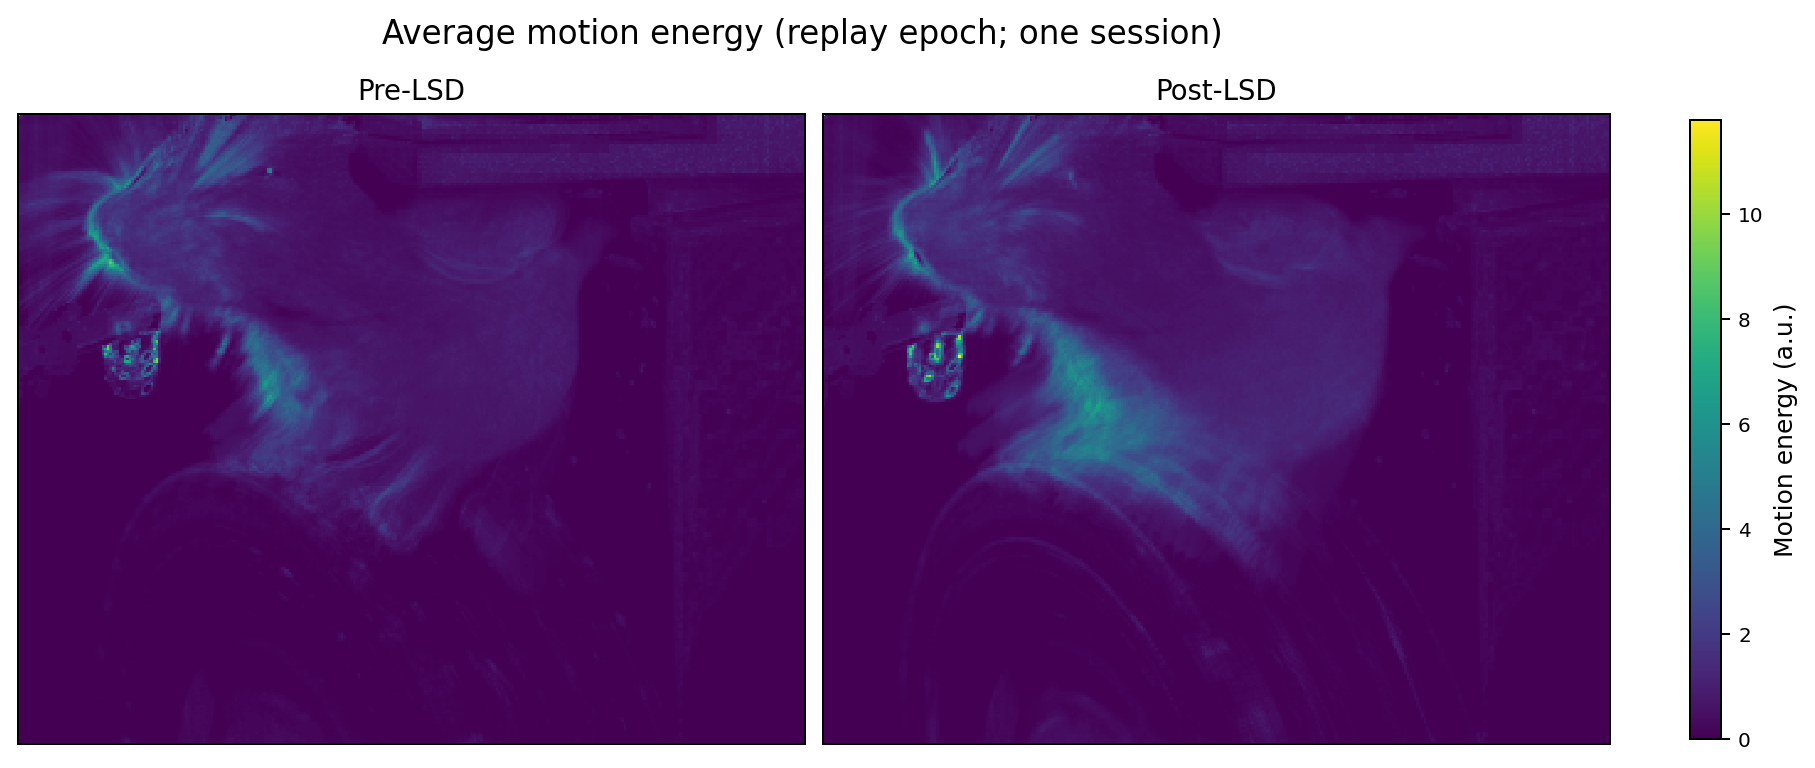

In [382]:
eid1 = exp_results['eid'].unique()[0]

pre1, post1 = load_pca_results(exp_results, eid1, epoch_name = 'replay')

avg_motion_pre = pre1.get('avgmotion_reshape')
avg_motion_post = post1.get('avgmotion_reshape')

import matplotlib.pyplot as plt

# Set clean, readable font style
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.titlesize': 11,
    'axes.titleweight': 'normal'
})

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Shared color limits
vmin = min(avg_motion_pre.min(), avg_motion_post.min())
vmax = max(avg_motion_pre.max(), avg_motion_post.max())

# Plot both images with the same colormap
im0 = axs[0].imshow(avg_motion_pre, cmap='viridis', vmin=vmin, vmax=vmax, interpolation='nearest')
im1 = axs[1].imshow(avg_motion_post, cmap='viridis', vmin=vmin, vmax=vmax, interpolation='nearest')

# Style individual subplots
for ax, title in zip(axs, ["Pre-LSD", "Post-LSD"]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    for spine in ax.spines.values():
        spine.set_visible(True)

# Add colorbar
cbar = fig.colorbar(im1, ax=axs, shrink=0.9, location='right')
cbar.set_label('Motion energy (a.u.)', fontsize = 10)

# Centered, clean figure title
fig.suptitle("Average motion energy (replay epoch; one session)", fontsize=13, x = 0.44, y=1.06)

plt.show()


Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18720, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (17920, 500)
singular value array has shape  (500,)


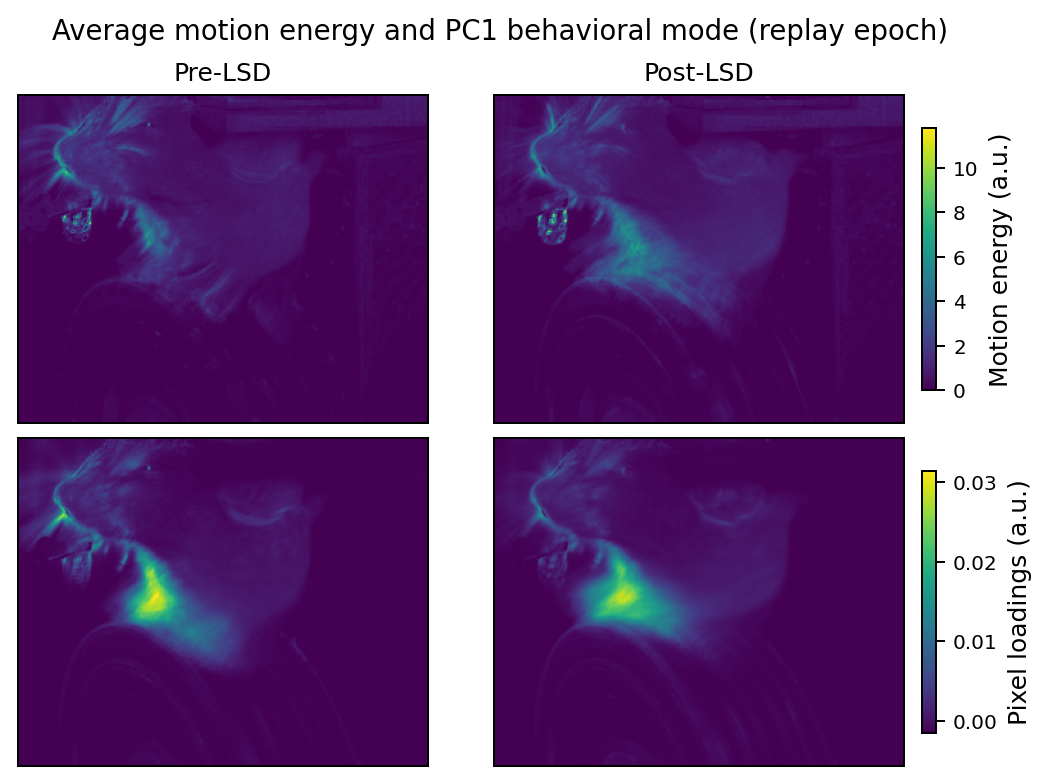

In [394]:
import matplotlib.pyplot as plt

# Font setup
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.titlesize': 11,
    'axes.titleweight': 'normal'
})

eid1 = exp_results['eid'].unique()[0]
pre_data, post_data = load_pca_results(exp_results, eid1, epoch_name = 'replay')

# Extract data
pre_PC,_,_= get_eigen(pre_data, reshaped=True)
post_PC,_,_= get_eigen(post_data, reshaped=True)


PC1_pre = pre_PC[:, :, 0]
PC1_post = post_PC[:, :, 0]

# Color limits
vmin_pc = min(PC1_pre.min(), PC1_post.min())
vmax_pc = max(PC1_pre.max(), PC1_post.max())
vmin_mot = min(avg_motion_pre.min(), avg_motion_post.min())
vmax_mot = max(avg_motion_pre.max(), avg_motion_post.max())

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 4), constrained_layout=True)
# Plot motion energy maps
im0 = axs[0, 0].imshow(avg_motion_pre, cmap='viridis', vmin=vmin_mot, vmax=vmax_mot)
im1 = axs[0, 1].imshow(avg_motion_post, cmap='viridis', vmin=vmin_mot, vmax=vmax_mot)

# Plot PC1 loading maps
im2 = axs[1, 0].imshow(PC1_pre, cmap='viridis', vmin=vmin_pc, vmax=vmax_pc)
im3 = axs[1, 1].imshow(PC1_post, cmap='viridis', vmin=vmin_pc, vmax=vmax_pc)

# Titles
axs[0, 0].set_title("Pre-LSD", fontsize = 10)
axs[0, 1].set_title("Post-LSD", fontsize = 10)

# Remove ticks and show borders
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)

# Colorbars
cbar0 = fig.colorbar(im0, ax=axs[0, :], orientation='vertical', shrink=0.8, pad=0.02)
cbar0.set_label("Motion energy (a.u.)", fontsize=10)

cbar1 = fig.colorbar(im2, ax=axs[1, :], orientation='vertical', shrink=0.8, pad=0.02)
cbar1.set_label("Pixel loadings (a.u.)", fontsize=10)
3
# Global title
fig.suptitle("Average motion energy and PC1 behavioral mode (replay epoch)", fontsize=11, y=1.05)

plt.show()

### Average Motion Energy changes

#### LSD

In [405]:
# differences

diff_spo = []
diff_rfm = []
diff_rep = []

# computing the average motion energy difference
# between pre/post phases (per protocol epoch)
for eid in exp_results['eid'].unique():
    
    # spontaneous
    pre1, post1 = load_pca_results(exp_results, eid, epoch_name = 'spontaneous')
    avg_motion_pre = pre1.get('avgmotion_reshape')
    avg_motion_post = post1.get('avgmotion_reshape')
    diff_spo.append(np.diff([avg_motion_pre, avg_motion_post], axis = 0))

    # rfm
    pre1, post1 = load_pca_results(exp_results, eid, epoch_name = 'rfm')
    avg_motion_pre = pre1.get('avgmotion_reshape')
    avg_motion_post = post1.get('avgmotion_reshape')
    diff_rfm.append(np.diff([avg_motion_pre, avg_motion_post], axis = 0))

    # replay
    pre1, post1 = load_pca_results(exp_results, eid, epoch_name = 'replay')
    avg_motion_pre = pre1.get('avgmotion_reshape')
    avg_motion_post = post1.get('avgmotion_reshape')
    diff_rep.append(np.diff([avg_motion_pre, avg_motion_post], axis = 0))

# Mean Avg. Motion Energy Difference
mean_diff_spo = np.mean(diff_spo, axis = 0)[0]
mean_diff_rfm = np.mean(diff_rfm, axis = 0)[0]
mean_diff_rep = np.mean(diff_rep, axis = 0)[0]

2.0813947


Text(0.5, 0.98, 'Average Motion Energy Change Across Epochs (LSD group)')

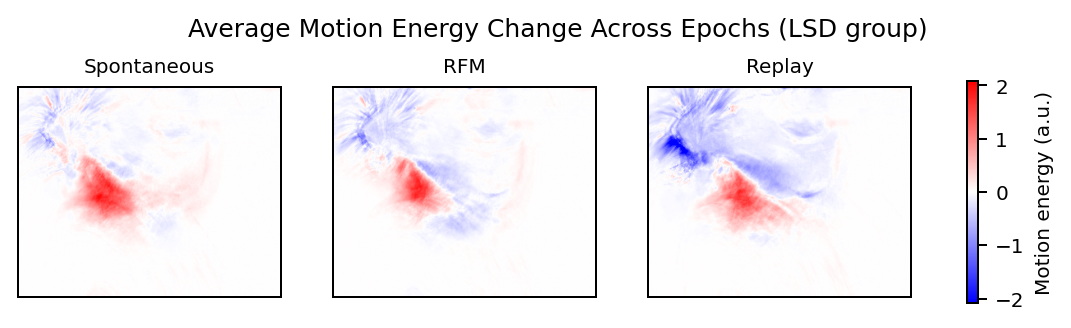

In [406]:
fig, axs = plt.subplots(ncols=3, figsize=(8, 2), constrained_layout=False)

#vmin_mot = min(avg_motion_pre.min(), avg_motion_post.min())
#vmin_mot = min(mean_diff_spo.min(), mean_diff_rfm.min(), mean_diff_rep.min())
vmax_mot = max(mean_diff_spo.max(), mean_diff_rfm.max(), mean_diff_rep.max())
vmin_mot = -vmax_mot
print(vmax_mot)
# Plot motion energy maps
im0 = axs[0].imshow(mean_diff_spo, cmap='bwr', vmin=vmin_mot, vmax=vmax_mot)
im1 = axs[1].imshow(mean_diff_rfm, cmap='bwr', vmin=vmin_mot, vmax=vmax_mot)
im2 = axs[2].imshow(mean_diff_rep, cmap='bwr', vmin=vmin_mot, vmax=vmax_mot)

# Style individual subplots
for ax, title in zip(axs, ["Spontaneous", "RFM", "Replay"]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize = 8)
    for spine in ax.spines.values():
        spine.set_visible(True)

# Add colorbar
cbar = fig.colorbar(im2, ax=axs, shrink=0.8, location='right')
cbar.set_label('Motion energy (a.u.)', fontsize = 8)

# Centered, clean figure title
fig.suptitle("Average Motion Energy Change Across Epochs (LSD group)", fontsize=10)


#### Saline

In [407]:
# differences
diff_spo = []
diff_rfm = []
diff_rep = []

# computing the average motion energy difference
# between pre/post phases (per protocol epoch)
for eid in cont_results['eid'].unique():
    
    # spontaneous
    pre1, post1 = load_pca_results(cont_results, eid, epoch_name = 'spontaneous')
    avg_motion_pre = pre1.get('avgmotion_reshape')
    avg_motion_post = post1.get('avgmotion_reshape')
    diff_spo.append(np.diff([avg_motion_pre, avg_motion_post], axis = 0))

    # rfm
    pre1, post1 = load_pca_results(cont_results, eid, epoch_name = 'rfm')
    avg_motion_pre = pre1.get('avgmotion_reshape')
    avg_motion_post = post1.get('avgmotion_reshape')
    diff_rfm.append(np.diff([avg_motion_pre, avg_motion_post], axis = 0))

    # replay
    pre1, post1 = load_pca_results(cont_results, eid, epoch_name = 'replay')
    avg_motion_pre = pre1.get('avgmotion_reshape')
    avg_motion_post = post1.get('avgmotion_reshape')
    diff_rep.append(np.diff([avg_motion_pre, avg_motion_post], axis = 0))

# Mean Avg. Motion Energy Difference
mean_diff_spo = np.mean(diff_spo, axis = 0)[0]
mean_diff_rfm = np.mean(diff_rfm, axis = 0)[0]
mean_diff_rep = np.mean(diff_rep, axis = 0)[0]

Text(0.5, 0.98, 'Average Motion Energy Change Across Epochs (Saline group)')

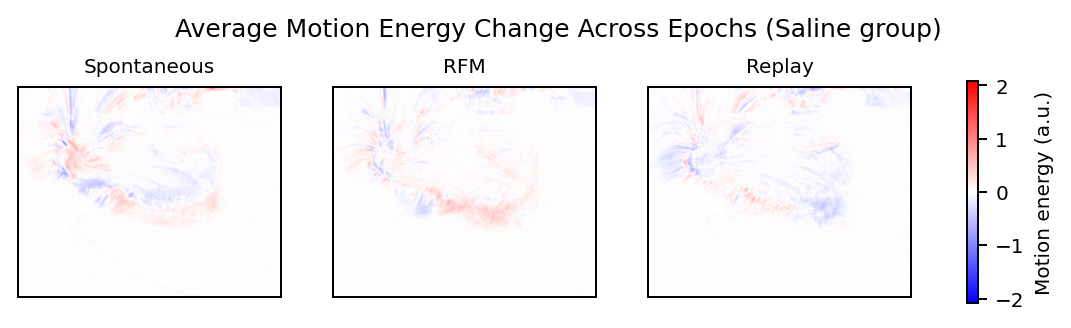

In [409]:
fig, axs = plt.subplots(ncols=3, figsize=(8, 2), constrained_layout=False)

#vmin_mot = min(avg_motion_pre.min(), avg_motion_post.min())
#vmin_mot = min(mean_diff_spo.min(), mean_diff_rfm.min(), mean_diff_rep.min())
vmax_mot =  2.0813947#max(mean_diff_spo.max(), mean_diff_rfm.max(), mean_diff_rep.max())
vmin_mot = -vmax_mot #-vmax_mot
# Plot motion energy maps
im0 = axs[0].imshow(mean_diff_spo, cmap='bwr', vmin=vmin_mot, vmax=vmax_mot)
im1 = axs[1].imshow(mean_diff_rfm, cmap='bwr', vmin=vmin_mot, vmax=vmax_mot)
im2 = axs[2].imshow(mean_diff_rep, cmap='bwr', vmin=vmin_mot, vmax=vmax_mot)

# Style individual subplots
for ax, title in zip(axs, ["Spontaneous", "RFM", "Replay"]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize = 8)
    for spine in ax.spines.values():
        spine.set_visible(True)

# Add colorbar
cbar = fig.colorbar(im2, ax=axs, shrink=0.8, location='right')
cbar.set_label('Motion energy (a.u.)', fontsize = 8)

# Centered, clean figure title
fig.suptitle("Average Motion Energy Change Across Epochs (Saline group)", fontsize=10)


## Explained Variance Plot

In [98]:
exp_pre = []
exp_post = []
for eid in cont_results['eid'].unique():

#eidx = exp_results['eid'].unique()[0]

#replay
    pre, post = load_pca_results(cont_results, eid, epoch_name='replay')

    pre_eigenmsk, _, pre_eigenval = get_eigen(pre)
    post_eigenmsk, _, post_eigenval = get_eigen(post)

    pre_explained_ratio = pre_eigenval/(pre_eigenval.sum())

    comp_pre = np.searchsorted(pre_explained_ratio.cumsum(), 0.8)+1
    exp_pre.append(comp_pre)

    print("First pre component explains: ", pre_explained_ratio[0])
    post_explained_ratio = post_eigenval/(post_eigenval.sum())

    comp_post = np.searchsorted(post_explained_ratio.cumsum(), 0.8)+1
    exp_post.append(comp_post)
    print("First postcomponent explains: ", post_explained_ratio[0])


Temporal PC matrix has shape (18780, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (16744, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
First pre component explains:  0.19366126
First postcomponent explains:  0.18130246
Temporal PC matrix has shape (18720, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (13837, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
First pre component explains:  0.24333078
First postcomponent explains:  0.21965095
Temporal PC matrix has shape (18720, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18780, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
First pre component explains:  0.22311313
First postcomponent explains:  0.2121737
Temporal PC matri

In [208]:
eid1 = exp_results['eid'].unique()[0]

pre, post = load_pca_results(cont_results, eid, epoch_name='replay')

_, _, pre_eigenval = get_eigen(pre)
_, _, post_eigenval = get_eigen(post)

pre_explained_ratio = pre_eigenval/(pre_eigenval.sum())

comp_pre = np.searchsorted(pre_explained_ratio.cumsum(), 0.7)+1
print("First pre component explains: ", pre_explained_ratio[0])
post_explained_ratio = post_eigenval/(post_eigenval.sum())

comp_post = np.searchsorted(post_explained_ratio.cumsum(), 0.7)+1


Temporal PC matrix has shape (18780, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18780, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
71
First pre component explains:  0.16053155
68


C:\Users\marti\AppData\Local\Temp\ipykernel_26124\1430186335.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(len(pre_explained_ratio))) + 1, np.log(pre_explained_ratio), color = 'red')


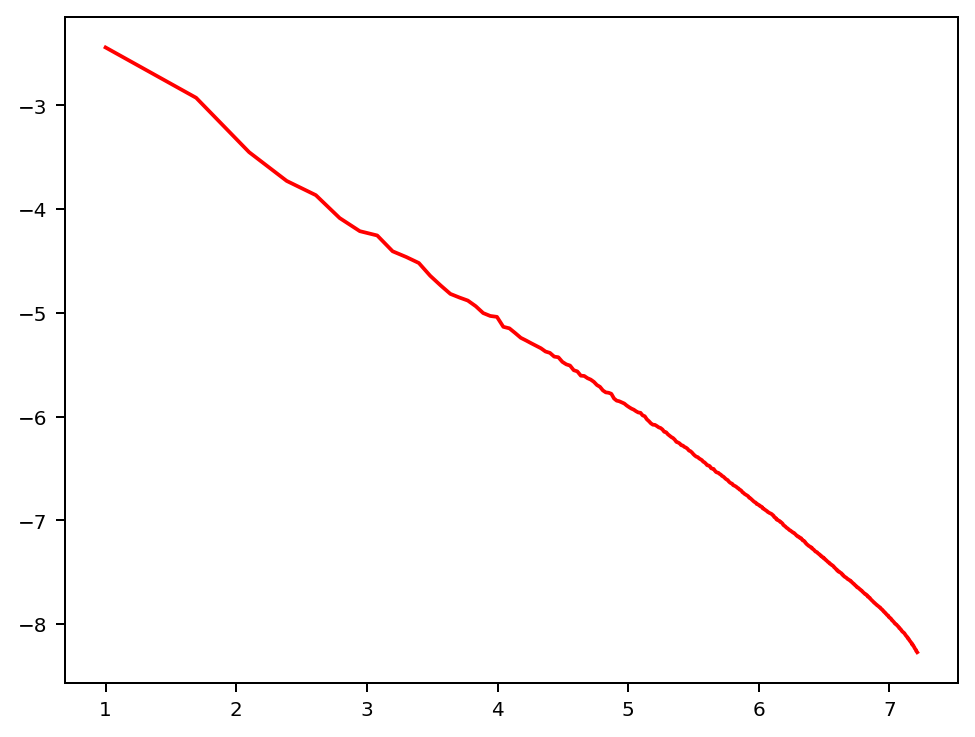

In [213]:
plt.plot(np.log(np.arange(len(pre_explained_ratio))) + 1, np.log(pre_explained_ratio), color = 'red')
#plt.plot(post_explained_ratio, color ='blue')

# y = x^a

It would be useful to plot the regression for presentation purposes

## Cosine Similarity

### Plotting Matrix

In [161]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from psyfun import util
k = 150 #<-- components to keep
similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)

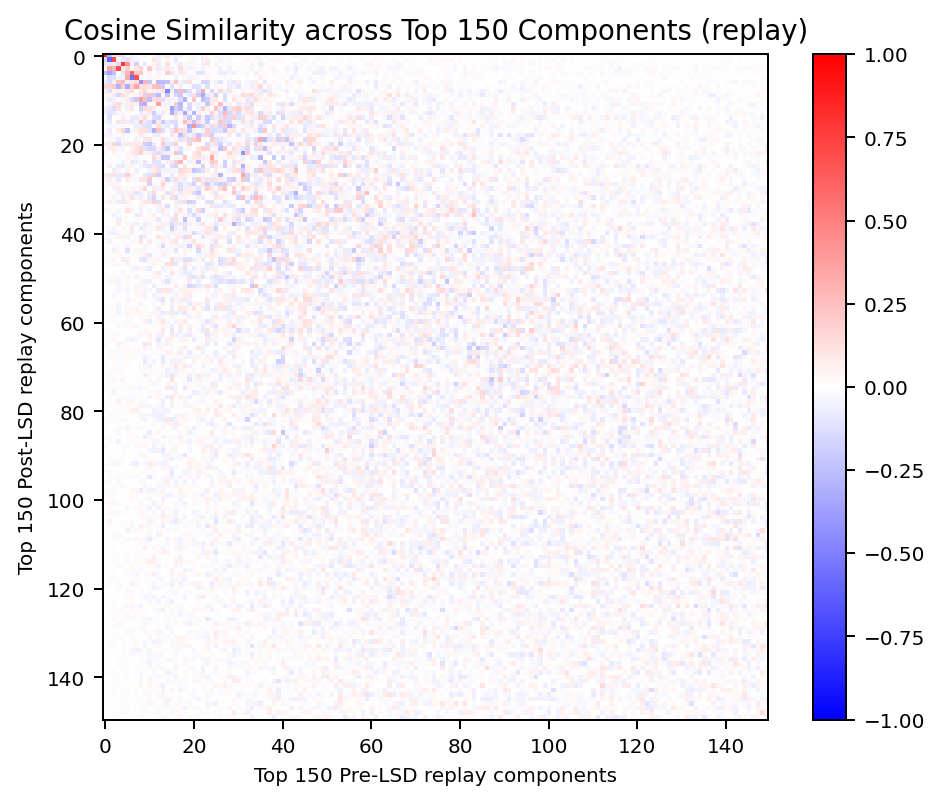

In [162]:
fig, ax0 = plt.subplots()
cax = ax0.imshow(similarity_matrix, cmap='bwr', vmin=-1, vmax=1)
ax0.set_title("Cosine Similarity across Top 150 Components (replay)")
ax0.set_xlabel("Top 150 Pre-LSD replay components")
ax0.set_ylabel("Top 150 Post-LSD replay components")
fig.colorbar(cax, ax=ax0)
plt.show()

### Analysis

#### Data

In [ ]:
all_data_similarity = extract_measure(exp_results, cont_results, metric = 'similarity', n_comps=150)

In [196]:
## experimental case
experimental = []
from sklearn.metrics.pairwise import cosine_similarity
from psyfun import util

k = 150 # <-- components to keep

for eid in exp_results['eid'].unique():
    for epoch in ['spontaneous', 'rfm', 'replay']:
        #eidx = exp_results['eid'].unique()[0]

        pre, post = load_pca_results(exp_results, eid, epoch_name=epoch)

        pre_eigenmsk, _, pre_eigenval = get_eigen(pre)
        post_eigenmsk, _, post_eigenval = get_eigen(post)

        # cosine similarity

        similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)
        
        # rowmax list
        max_similarity = np.max(np.abs(similarity_matrix), axis = 0)

        # average value
        experimental.append((eid, epoch, np.mean(max_similarity)))



## control case
control = []
from sklearn.metrics.pairwise import cosine_similarity
from psyfun import util

for eid in cont_results['eid'].unique():
    for epoch in ['spontaneous', 'rfm', 'replay']:
        pre, post = load_pca_results(cont_results, eid, epoch_name=epoch)

        pre_eigenmsk, _, pre_eigenval = get_eigen(pre)
        post_eigenmsk, _, post_eigenval = get_eigen(post)

        # cosine similarity

        similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)
        
        # rowmax list
        max_similarity = np.max(np.abs(similarity_matrix), axis = 0)

        # average value
        control.append((eid, epoch, np.mean(max_similarity)))   

Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (23040, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (24180, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18720, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (17920, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has s

In [197]:
# replay cosine similarity comparison

exp_data = pd.DataFrame(experimental, columns = ['eid', 'epoch', 'avg_sim'])
control_data = pd.DataFrame(control, columns = ['eid', 'epoch', 'avg_sim'])


#### tests

In [199]:
from scipy import stats
import seaborn as sns
exp_val = exp_data['avg_sim'][exp_data['epoch'] == 'spontaneous']
control_val= control_data['avg_sim'][control_data['epoch'] == 'spontaneous']

ttest = stats.ttest_ind(exp_val, control_val, equal_var=False)
print(ttest)

# t = 0.67, p = 0.51
exp_val = exp_data['avg_sim'][exp_data['epoch'] == 'rfm']
control_val= control_data['avg_sim'][control_data['epoch'] == 'rfm']

ttest = stats.ttest_ind(exp_val, control_val, equal_var=False)
print(ttest)

#t = 1.29, p=  0.21

exp_val = exp_data['avg_sim'][exp_data['epoch'] == 'replay']
control_val= control_data['avg_sim'][control_data['epoch'] == 'replay']

ttest = stats.ttest_ind(exp_val, control_val, equal_var=False)
print(ttest)
# t = -0.21, p = 0.83


TtestResult(statistic=0.8116756273070764, pvalue=0.43377226425099225, df=11.279845126053191)
TtestResult(statistic=1.1953938578166505, pvalue=0.25206696689123365, df=13.803339836713368)
TtestResult(statistic=-0.6991176464781466, pvalue=0.49078649872024127, df=25.58236872171554)


In [200]:
from scipy import stats
import pingouin as pg

exp_data['condition'] = 'LSD'
control_data['condition'] = 'Saline'

all_data = pd.concat([exp_data, control_data], ignore_index=True)

anova = pg.mixed_anova(
                        dv = 'avg_sim',
                        within ='epoch',
                        between = 'condition',
                        subject = 'eid',
                        data = all_data)

print(anova)



        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0    condition  0.000620    1   34  0.000620   0.443269  0.510041  0.012870   
1        epoch  0.018807    2   68  0.009403  15.314165  0.000003  0.310543   
2  Interaction  0.001557    2   68  0.000778   1.267642  0.288061  0.035943   

        eps  
0       NaN  
1  0.975227  
2       NaN  


c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


C:\Users\marti\AppData\Local\Temp\ipykernel_26124\2148671698.py:7: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  ax1 = sns.stripplot(data=all_data, x='epoch', y='avg_sim', hue = 'condition', color='black', size=2, jitter=False, dodge=True, ax=ax, legend=None)


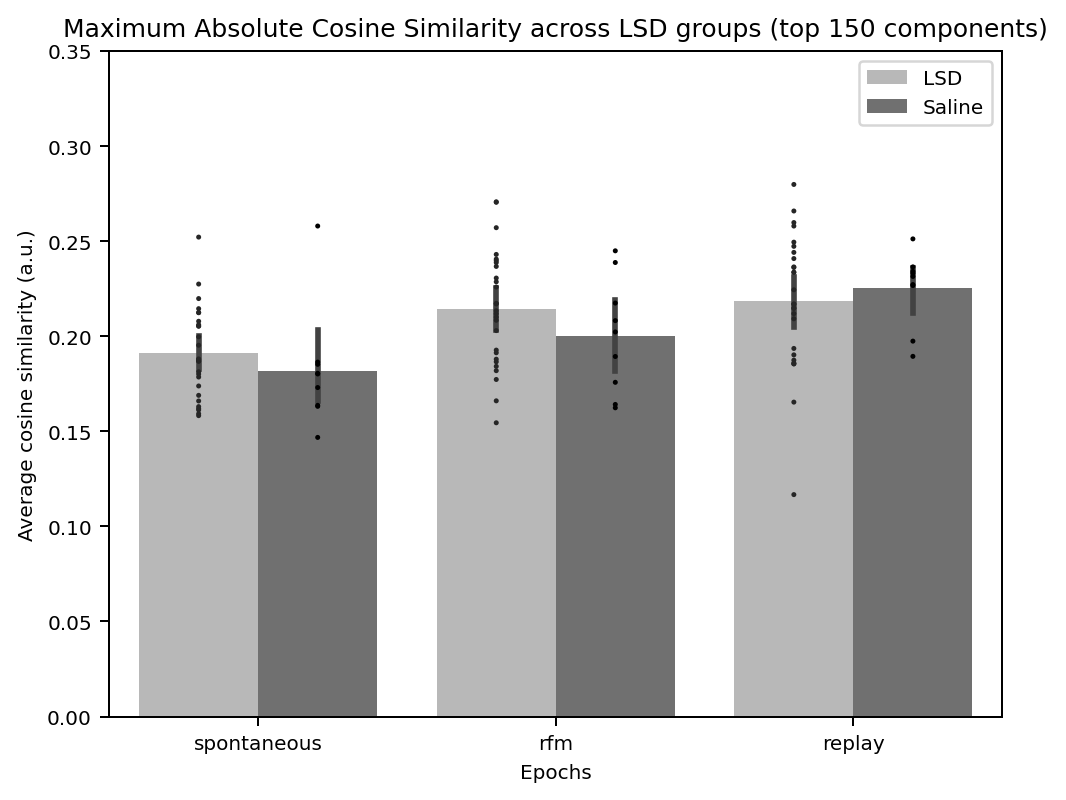

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

gray_blue_palette = ['#b8b8b8', '#707070']  # light and dark gray-blue

ax = sns.barplot(data=all_data, x='epoch', y='avg_sim', hue='condition', palette=gray_blue_palette)
ax1 = sns.stripplot(data=all_data, x='epoch', y='avg_sim', hue = 'condition', color='black', size=2, jitter=False, dodge=True, ax=ax, legend=None)

ax.legend(title = "Condition", title_fontsize = 8, fontsize = 8)
ax1.legend()
plt.title('Maximum Absolute Cosine Similarity across LSD groups (top 150 components)', fontsize = 10)
plt.ylabel('Average cosine similarity (a.u.)')
plt.xlabel("Epochs")
plt.ylim(0, 0.35)
plt.show()


post hoc

In [193]:
posthoc = pg.pairwise_tests(dv='avg_sim', within='epoch', subject='eid', parametric=False, data=exp_data, padjust='none')
print(posthoc)

  Contrast       A            B  Paired  Parametric  W-val alternative  \
0    epoch  replay          rfm    True       False  172.0   two-sided   
1    epoch  replay  spontaneous    True       False   52.0   two-sided   
2    epoch     rfm  spontaneous    True       False   58.0   two-sided   

      p-unc    hedges  
0  0.696386  0.131548  
1  0.000536  0.901801  
2  0.001021  0.836071  


In [191]:
posthoc = pg.pairwise_tests(dv='avg_sim', within='epoch', subject='eid', parametric=True, data=control_data, padjust='none')
print(posthoc)

  Contrast       A            B  Paired  Parametric         T  dof  \
0    epoch  replay          rfm    True        True  3.080222  8.0   
1    epoch  replay  spontaneous    True        True  3.770810  8.0   
2    epoch     rfm  spontaneous    True        True  1.851112  8.0   

  alternative     p-unc    BF10    hedges  
0   two-sided  0.015112   4.589  0.931706  
1   two-sided  0.005459  10.313  1.585020  
2   two-sided  0.101304   1.086  0.572699  


significant analysis here depends on how these "change" metrics compare to the control case. That way, I could claim some sort of significant behavioral change upon LSD administration

possible next steps:
- subplane similarity analysis. take top k (argmax) components from individual pair cos analysis and compare the basis. This could give a more nuanced comparison in behavioral change, but I'm afraid the angle intuition necessarily get lost.
- the fact that it's two different motif basis is getting on my nerves. Lempel-ziv


same thing but with 3 

Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (23040, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (24180, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18720, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (17920, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has shape (18000, 500)
Eigenmask matrix has shape  (81920, 500)
singular value array has shape  (500,)
Temporal PC matrix has s

C:\Users\marti\AppData\Local\Temp\ipykernel_26124\3887960789.py:79: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  ax1 = sns.stripplot(data=all_data, x='epoch', y='avg_sim', hue = 'condition', color='black', size=2, jitter=False, dodge=True, ax=ax, legend=None)


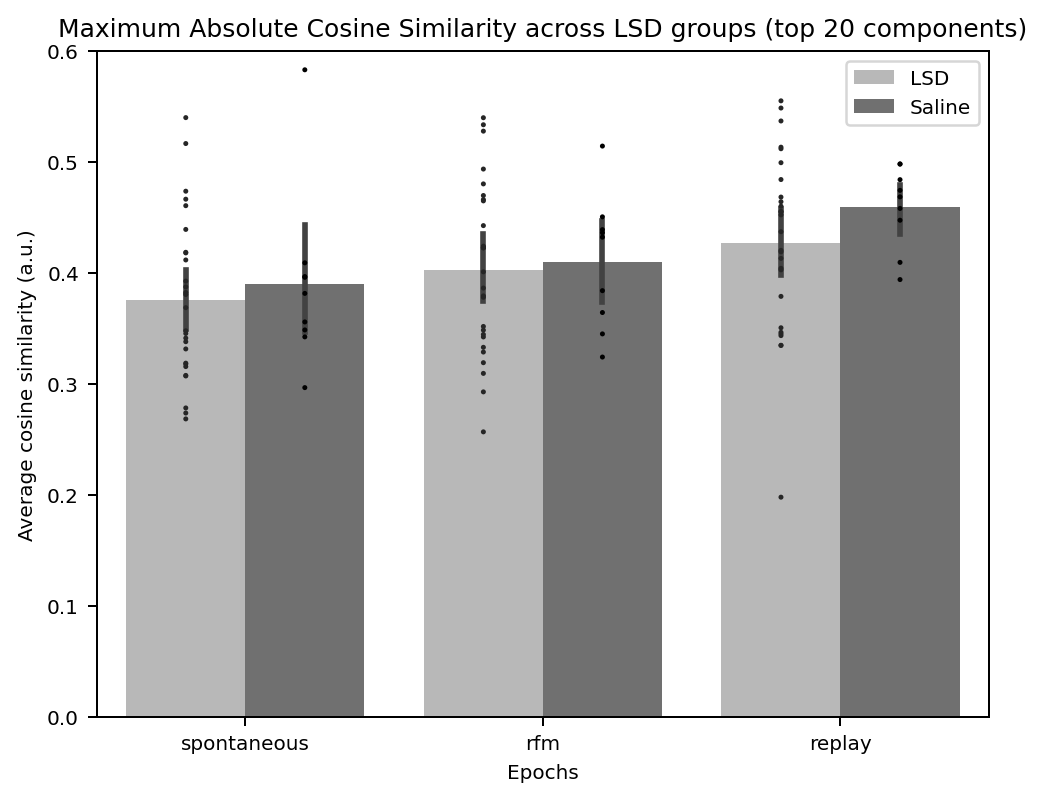

In [205]:
## experimental case
from scipy import stats
import pingouin as pg
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

k = 20 # <-- components to keep

experimental = []
for eid in exp_results['eid'].unique():
    for epoch in ['spontaneous', 'rfm', 'replay']:
        #eidx = exp_results['eid'].unique()[0]

        pre, post = load_pca_results(exp_results, eid, epoch_name=epoch)

        pre_eigenmsk, _, pre_eigenval = get_eigen(pre)
        post_eigenmsk, _, post_eigenval = get_eigen(post)

        # cosine similarity

        similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)
        
        # rowmax list
        max_similarity = np.max(np.abs(similarity_matrix), axis = 0)

        # average value
        experimental.append((eid, epoch, np.mean(max_similarity)))



## control case

control = []
for eid in cont_results['eid'].unique():
    for epoch in ['spontaneous', 'rfm', 'replay']:
        pre, post = load_pca_results(cont_results, eid, epoch_name=epoch)

        pre_eigenmsk, _, pre_eigenval = get_eigen(pre)
        post_eigenmsk, _, post_eigenval = get_eigen(post)

        # cosine similarity
        similarity_matrix = cosine_similarity(pre_eigenmsk.T[:k,:], post_eigenmsk[:,:k].T)
        
        # rowmax list
        max_similarity = np.max(np.abs(similarity_matrix), axis = 0)

        # average value
        control.append((eid, epoch, np.mean(max_similarity)))   



#  dataframe
exp_data = pd.DataFrame(experimental, columns = ['eid', 'epoch', 'avg_sim'])
control_data = pd.DataFrame(control, columns = ['eid', 'epoch', 'avg_sim'])

# MIXED ANOVA


exp_data['condition'] = 'LSD'
control_data['condition'] = 'Saline'

all_data = pd.concat([exp_data, control_data], ignore_index=True)

anova = pg.mixed_anova(
                        dv = 'avg_sim',
                        within ='epoch',
                        between = 'condition',
                        subject = 'eid',
                        data = all_data)

print(anova)



gray_blue_palette = ['#b8b8b8', '#707070']  # light and dark gray-blue

ax = sns.barplot(data=all_data, x='epoch', y='avg_sim', hue='condition', palette=gray_blue_palette)
ax1 = sns.stripplot(data=all_data, x='epoch', y='avg_sim', hue = 'condition', color='black', size=2, jitter=False, dodge=True, ax=ax, legend=None)

ax.legend(title = "Condition", title_fontsize = 8, fontsize = 8)
ax1.legend()
plt.title(f'Maximum Absolute Cosine Similarity across LSD groups (top {k} components)', fontsize = 10)
plt.ylabel('Average cosine similarity (a.u.)')
plt.xlabel("Epochs")
plt.ylim(0, 0.6)
plt.show()

In [183]:
exp_data['condition'] = 'LSD'
control_data['condition'] = 'Saline'

all_data = pd.concat([exp_data, control_data], ignore_index=True)

anova = pg.mixed_anova(
                        dv = 'similarity',
                        within ='epoch',
                        between = 'condition',
                        subject = 'eid',
                        data = all_data)

print(anova)



gray_blue_palette = ['#b8b8b8', '#707070']  # light and dark gray-blue
ax = sns.barplot(data=all_data, x='epoch', y='avg_sim', hue='condition', palette=LSD_CONT_palette)

ax1 = sns.stripplot(data=all_data, x='epoch', y='avg_sim', hue = 'condition', color='black', size=2, jitter=False, dodge=True, ax=ax, legend=None)

ax.legend(title = "Condition", title_fontsize = 8, fontsize = 8)
ax1.legend()
plt.title(f'Maximum Absolute Cosine Similarity across LSD groups (top {k} components)', fontsize = 10)
plt.ylabel('Average cosine similarity (a.u.)')
plt.xlabel("Epochs")
plt.ylim(0, 0.7)
plt.show()

KeyError: 'avg_sim'

## Power Law Slope

### Data: slope change

In [48]:
## experimental case
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from psyfun import util

k = 150 # <-- components to keep

experimental = []
for eid in exp_results['eid'].unique():
    for epoch in ['spontaneous', 'rfm', 'replay']:
        #eidx = exp_results['eid'].unique()[0]

        pre, post = load_pca_results(exp_results, eid, epoch_name=epoch)

        _, _, pre_eigenval = get_eigen(pre)
        _, _, post_eigenval = get_eigen(post)

        # power law
        
        slope_pre = util.power_law_slope(pre_eigenval, k)
        slope_post = util. power_law_slope(post_eigenval, k)

        #experimental.append((eid, epoch, slope_pre, 'pre'))
        #experimental.append((eid, epoch, slope_post, 'post'))
        experimental.append((eid, epoch, slope_post - slope_pre))
        

## control case

control = []
for eid in cont_results['eid'].unique():
    for epoch in ['spontaneous', 'rfm', 'replay']:
        pre, post = load_pca_results(cont_results, eid, epoch_name=epoch)

        _, _, pre_eigenval = get_eigen(pre)
        _, _, post_eigenval = get_eigen(post)

        slope_pre = util.power_law_slope(pre_eigenval, k)
        slope_post = util. power_law_slope(post_eigenval, k)

        #control.append((eid, epoch, slope_pre, 'pre'))
        #control.append((eid, epoch, slope_post, 'post')) 
        control.append((eid, epoch, slope_post - slope_pre))



#  dataframe
#exp_data = pd.DataFrame(experimental, columns = ['eid', 'epoch', 'pow_law', 'time'])
# control_data = pd.DataFrame(control, columns = ['eid', 'epoch', 'pow_law', 'time'])
exp_data = pd.DataFrame(experimental, columns = ['eid', 'epoch', 'pow_law'])
control_data = pd.DataFrame(control, columns = ['eid', 'epoch', 'pow_law'])

# MIXED ANOVA

exp_data['condition'] = 'LSD'
control_data['condition'] = 'Saline'

all_data = pd.concat([exp_data, control_data], ignore_index=True)

Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (23040, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (24180, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18720, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (17920, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has sha

In [55]:
all_data['condition'] = all_data['condition'].astype('category')
all_data['epoch'] = all_data['epoch'].astype('category')
all_data['epoch'] = pd.Categorical(all_data['epoch'], categories=['spontaneous', 'rfm', 'replay'], ordered=True)
#all_data['time'] = all_data['time'].astype('category')

#setting order
#all_data['time'] = pd.Categorical(all_data['time'], categories=['pre', 'post'], ordered=True)

In [56]:
spo_df = all_data.query("epoch == 'spontaneous'")
rfm_df = all_data.query("epoch == 'rfm'")
replay_df = all_data.query("epoch == 'replay'")

### tests

#### penguin approach -- one within factor

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0    condition  0.029540    1   34  0.029540  17.508541  0.000190  0.339915   
1        epoch  0.008524    2   68  0.004262   4.526055  0.014277  0.117480   
2  Interaction  0.002090    2   68  0.001045   1.109941  0.335475  0.031613   

        eps  
0       NaN  
1  0.985396  
2       NaN  


C:\Users\marti\AppData\Local\Temp\ipykernel_19660\2424697779.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(data=all_data, x='epoch', y='pow_law', hue='condition', palette=gray_blue_palette, ci = 95, errwidth=0, dodge = True)
C:\Users\marti\AppData\Local\Temp\ipykernel_19660\2424697779.py:16: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.barplot(data=all_data, x='epoch', y='pow_law', hue='condition', palette=gray_blue_palette, ci = 95, errwidth=0, dodge = True)
C:\Users\marti\AppData\Local\Temp\ipykernel_19660\2424697779.py:17: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  ax1 = sns.stripplot(data=all_data, x='epoch', y='pow_law', hue = 'condition', color='black', size=2, alpha = 0.7, jitter=True, dodge=True,

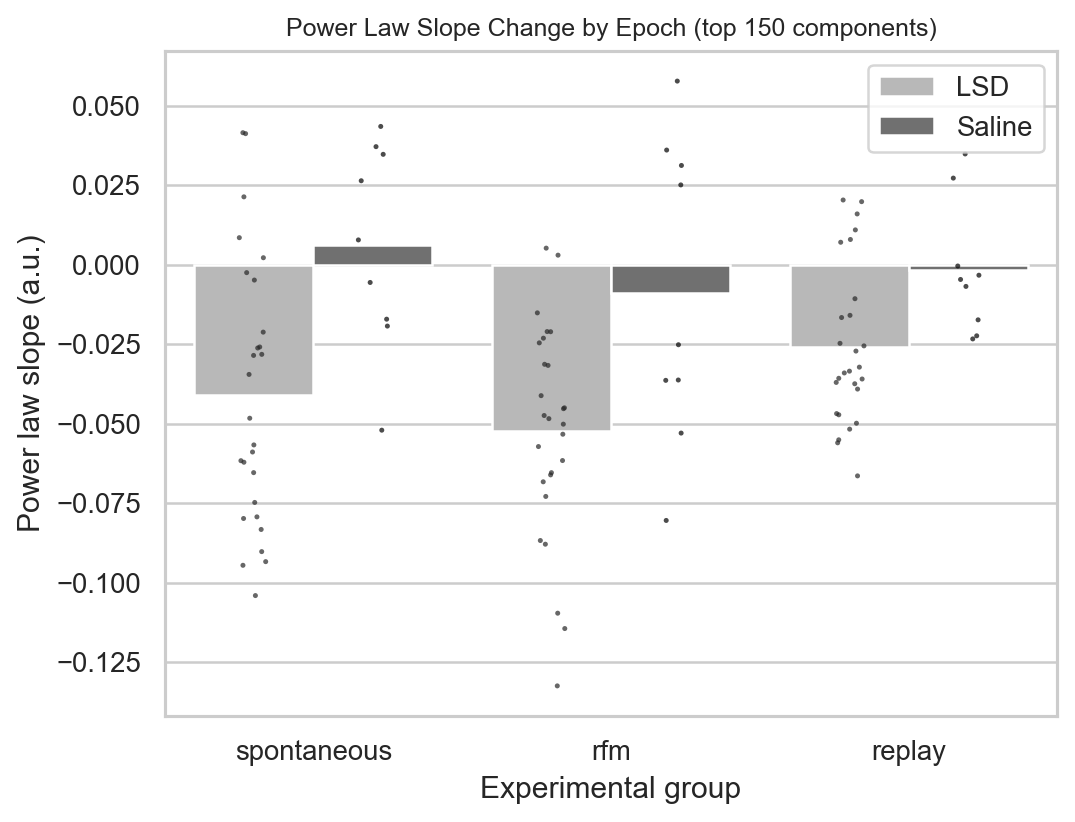

In [63]:
epoch_df = rfm_df # <-- target epoch

anova = pg.mixed_anova(
                        dv = 'pow_law',
                        within = 'epoch', # change back to 'time'
                        between = 'condition',
                        subject = 'eid',
                        data = all_data)

print(anova)



gray_blue_palette = ['#b8b8b8', '#707070']  # light and dark gray-blue

ax = sns.barplot(data=all_data, x='epoch', y='pow_law', hue='condition', palette=gray_blue_palette, ci = 95, errwidth=0, dodge = True)
ax1 = sns.stripplot(data=all_data, x='epoch', y='pow_law', hue = 'condition', color='black', size=2, alpha = 0.7, jitter=True, dodge=True, ax=ax, legend=None)

ax.legend(title = "Administration", title_fontsize = 8, fontsize = 8)
ax1.legend()
plt.title(f'Power Law Slope Change by Epoch (top {k} components)', fontsize = 10)

plt.ylabel('Power law slope (a.u.)')
plt.xlabel("Experimental group")
plt.show()

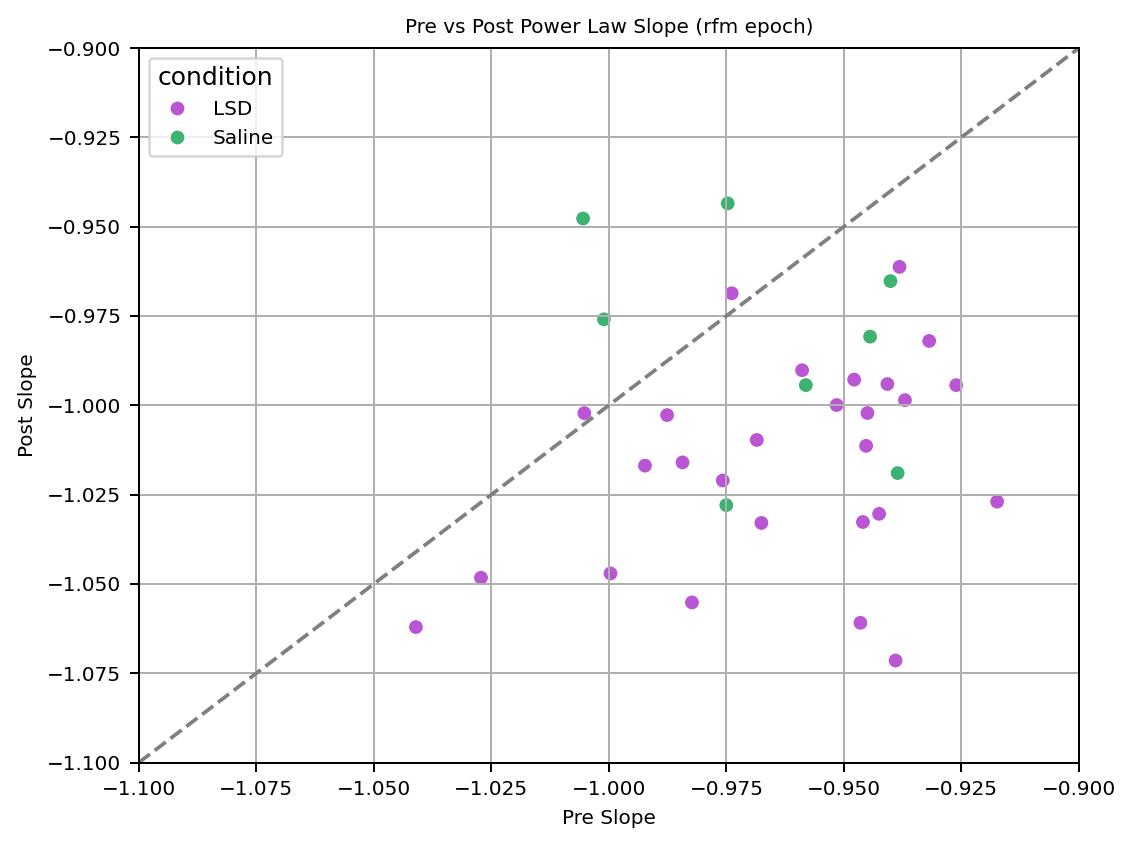

In [22]:
epoch_df_pv = epoch_df.pivot(index=['eid', 'condition', 'epoch'], columns='time', values='pow_law').reset_index()
epoch_df_pv.columns.name = None  



sns.scatterplot(data = epoch_df_pv, x = 'pre', y = 'post', hue = 'condition', palette = LSD_CONT_palette)
plt.plot([-1.1, 0.9], [-1.1, 0.9], linestyle='--', color='gray')

plt.xlabel("Pre Slope")
plt.ylabel("Post Slope")
plt.title("Pre vs Post Power Law Slope (rfm epoch)")
plt.grid(True)
plt.ylim(-1.1, -0.9)
plt.xlim(-1.1, -0.9)
plt.tight_layout()
plt.show()



  Contrast    A     B  Paired  Parametric  W-val alternative         p-unc  \
0     time  pre  post    True       False    3.0   two-sided  7.450581e-08   

     hedges  
0  1.731393  
  Contrast    A     B  Paired  Parametric  W-val alternative     p-unc  \
0     time  pre  post    True       False   16.0   two-sided  0.496094   

     hedges  
0  0.248526  


C:\Users\marti\AppData\Local\Temp\ipykernel_19660\1538007389.py:13: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  ax1 = sns.stripplot(data=epoch_df, x='condition', y='pow_law', hue = 'time', color='black', size=2, jitter=False, dodge=True, ax=ax, legend=None)


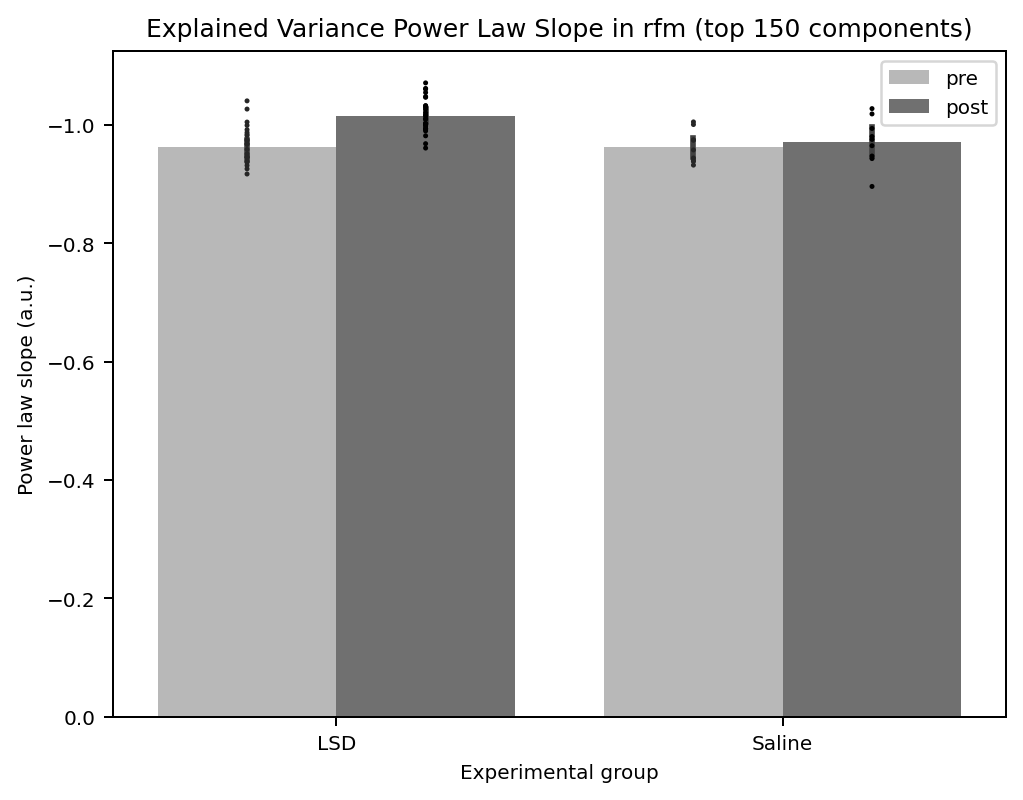

In [23]:
# Pre vs Post slopes within LSD group
lsd = pg.pairwise_tests(dv='pow_law', within='time', between=None, 
                   subject='eid', data=epoch_df[epoch_df['condition'] == 'LSD'], parametric=False)
                   
# Pre vs Post slopes within Control group
control = pg.pairwise_tests(dv='pow_law', within='time', between=None, 
                   subject='eid', data=epoch_df[epoch_df['condition'] == 'Saline'], parametric= False)

print(lsd)
print(control)

ax = sns.barplot(data=epoch_df, x='condition', y='pow_law', hue='time', palette=gray_blue_palette)
ax1 = sns.stripplot(data=epoch_df, x='condition', y='pow_law', hue = 'time', color='black', size=2, jitter=False, dodge=True, ax=ax, legend=None)

ax.invert_yaxis()

ax.legend(title = "Administration", title_fontsize = 8, fontsize = 8)
ax1.legend()
plt.title(f'Explained Variance Power Law Slope in rfm (top {k} components)', fontsize = 10)
plt.ylabel('Power law slope (a.u.)')
plt.xlabel("Experimental group")
plt.show()

#### statsmodel approach

In [47]:
import statsmodels.formula.api as smf
import statsmodels

model = smf.mixedlm(
            formula= "pow_law ~ time * epoch * condition",
            data = all_data,
            groups = 'eid')

result = model.fit()

print(result.summary())

                              Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               pow_law 
No. Observations:                 216                   Method:                           REML    
No. Groups:                       36                    Scale:                            0.0006  
Min. group size:                  6                     Log-Likelihood:                   431.4208
Max. group size:                  6                     Converged:                        Yes     
Mean group size:                  6.0                                                             
--------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [33]:
import itertools
import pandas as pd

# All combinations of the fixed factors
factors = list(itertools.product(
    all_data['time'].unique(),
    all_data['epoch'].unique(),
    all_data['condition'].unique()
))

predict_df = pd.DataFrame(factors, columns=['time', 'epoch', 'condition'])

# Add dummy subject (since 'groups' is required)
predict_df['eid'] = all_data['eid'].iloc[0]




,time,epoch,condition,eid
0,pre,spontaneous,LSD,58ca39c5-e27f-43c4-8516-2ccc4fe88042
1,pre,spontaneous,Saline,58ca39c5-e27f-43c4-8516-2ccc4fe88042
2,pre,rfm,LSD,58ca39c5-e27f-43c4-8516-2ccc4fe88042
3,pre,rfm,Saline,58ca39c5-e27f-43c4-8516-2ccc4fe88042
4,pre,replay,LSD,58ca39c5-e27f-43c4-8516-2ccc4fe88042
5,pre,replay,Saline,58ca39c5-e27f-43c4-8516-2ccc4fe88042
6,post,spontaneous,LSD,58ca39c5-e27f-43c4-8516-2ccc4fe88042
7,post,spontaneous,Saline,58ca39c5-e27f-43c4-8516-2ccc4fe88042
8,post,rfm,LSD,58ca39c5-e27f-43c4-8516-2ccc4fe88042
9,post,rfm,Saline,58ca39c5-e27f-43c4-8516-2ccc4fe88042


In [35]:
predict_df['predicted'] = result.predict(predict_df)


In [36]:
predict_df['predicted_full'] = result.predict(exog=predict_df)


C:\Users\marti\AppData\Local\Temp\ipykernel_19660\4279051136.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.pointplot(


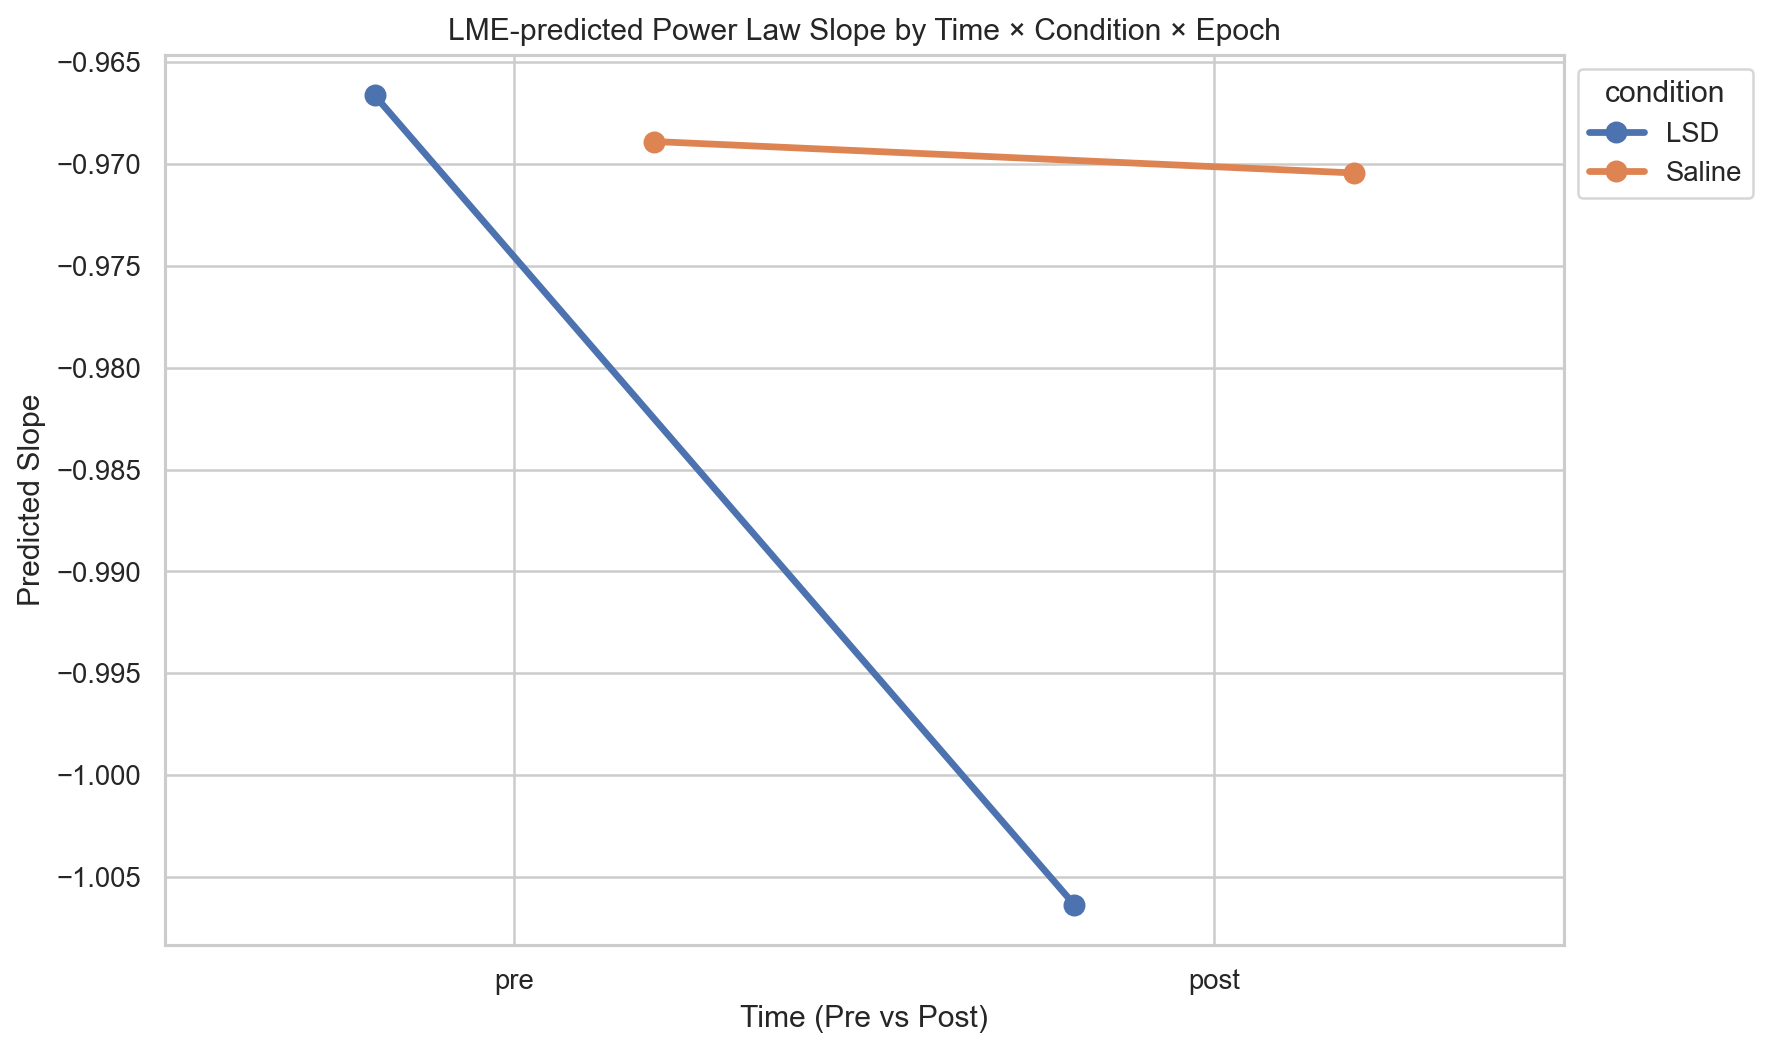

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.pointplot(
    data=predict_df,
    x='time', y='predicted',
    hue='condition',
    dodge=0.4,
    ci=None,
    markers='o',
    linestyles='-',
    palette='deep'
)

# Add separate lines for each epoch
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title("LME-predicted Power Law Slope by Time × Condition × Epoch")
plt.ylabel("Predicted Slope")
plt.xlabel("Time (Pre vs Post)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [184]:

gray_blue_palette = ['#b8b8b8', '#707070']  # light and dark gray-blue

ax = sns.barplot(data=epoch_df, x='condition', y='pow_law', hue='time', palette=gray_blue_palette)
ax1 = sns.stripplot(data=epoch_df, x='condition', y='pow_law', hue = 'time', color='black', size=2, jitter=False, dodge=True, ax=ax, legend=None)

ax.legend(title = "Administration", title_fontsize = 8, fontsize = 8)
ax1.legend()
ax.invert_yaxis()
plt.title(f'Explained Variance Power Law Slope (top {k} components; replay. epoch)', fontsize = 10)

plt.ylabel('Power law slope (a.u.)')
plt.xlabel("Experimental group")
plt.show()

ValueError: Could not interpret value `pow_law` for `y`. An entry with this name does not appear in `data`.

## Zempel-Ziv

In [170]:
all_data_entropy = extract_measure(exp_results, cont_results, metric = 'entropy', n_comps=150)

Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (23040, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (24180, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18720, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (17920, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has sha

In [133]:
## experimental case
from scipy import stats
import pingouin as pg
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from psyfun import util

k = 150 # <-- components to keep

experimental = []
for eid in exp_results['eid'].unique():
    for epoch in ['spontaneous', 'rfm', 'replay']:
        #eidx = exp_results['eid'].unique()[0]

        pre, post = load_pca_results(exp_results, eid, epoch_name=epoch)

        _, temp_pre, _ = get_eigen(pre)
        _, temp_post,_ = get_eigen(post)

        # n_components x n_frames
        temp_pre = temp_pre.T
        temp_post = temp_post.T
        # lempel ziv scores for each component
        
        pre_lzentropy = compute_lz_entropy(temp_pre, k).mean(axis = 0)
        post_lzentropy = compute_lz_entropy(temp_post, k).mean(axis =0)

        experimental.append((eid, epoch, pre_lzentropy, 'pre'))
        experimental.append((eid, epoch, post_lzentropy, 'post'))
        

## control case

control = []
for eid in cont_results['eid'].unique():
    for epoch in ['spontaneous', 'rfm', 'replay']:
        pre, post = load_pca_results(cont_results, eid, epoch_name=epoch)

        _, temp_pre, _ = get_eigen(pre)
        _, temp_post,_ = get_eigen(post)

        # n_components x n_frames
        temp_pre = temp_pre.T
        temp_post = temp_post.T
        
        # lempel ziv scores for each component
        
        pre_lzentropy = compute_lz_entropy(temp_pre, k).mean(axis =0)
        post_lzentropy = compute_lz_entropy(temp_post, k).mean(axis =0)

        control.append((eid, epoch, pre_lzentropy, 'pre'))
        control.append((eid, epoch, post_lzentropy, 'post'))



#  dataframe
exp_data = pd.DataFrame(experimental, columns = ['eid', 'epoch', 'lz_entropy', 'time'])
control_data = pd.DataFrame(control, columns = ['eid', 'epoch', 'lz_entropy', 'time'])


# MIXED ANOVA
exp_data['condition'] = 'LSD'
control_data['condition'] = 'Saline'

Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (23040, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (24180, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18720, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (17920, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
Eigenmask matrix has sha

In [135]:
all_data = pd.concat([exp_data, control_data], ignore_index=True)

In [136]:
all_data['condition'] = all_data['condition'].astype('category')

# epoch ordering
all_data['epoch'] = all_data['epoch'].astype('category')
all_data['epoch'] = pd.Categorical(all_data['epoch'], categories=['spontaneous', 'rfm', 'replay'], ordered=True)

# pre/post ordering
all_data['time'] = all_data['time'].astype('category')
all_data['time'] = pd.Categorical(all_data['time'], categories=['pre', 'post'], ordered=True)

In [137]:
spo_df = all_data.query("epoch == 'spontaneous'")
rfm_df = all_data.query("epoch == 'rfm'")
replay_df = all_data.query("epoch == 'replay'")

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0    condition  0.000167    1   34  0.000167  18.146510  0.000153  0.347991   
1         time  0.000005    1   34  0.000005   0.917315  0.344942  0.026271   
2  Interaction  0.000002    1   34  0.000002   0.368584  0.547811  0.010724   

   eps  
0  NaN  
1  1.0  
2  NaN  


C:\Users\marti\AppData\Local\Temp\ipykernel_19660\2376323937.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(data=epoch_df, x='condition', y='lz_entropy', hue='time', palette=gray_blue_palette, ci = 95, errwidth=0, dodge = True)
C:\Users\marti\AppData\Local\Temp\ipykernel_19660\2376323937.py:16: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.barplot(data=epoch_df, x='condition', y='lz_entropy', hue='time', palette=gray_blue_palette, ci = 95, errwidth=0, dodge = True)
C:\Users\marti\AppData\Local\Temp\ipykernel_19660\2376323937.py:17: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  ax1 = sns.stripplot(data=epoch_df, x='condition', y='lz_entropy', hue = 'time', color='black', size=2, alpha = 0.7, jitter=False, dodg

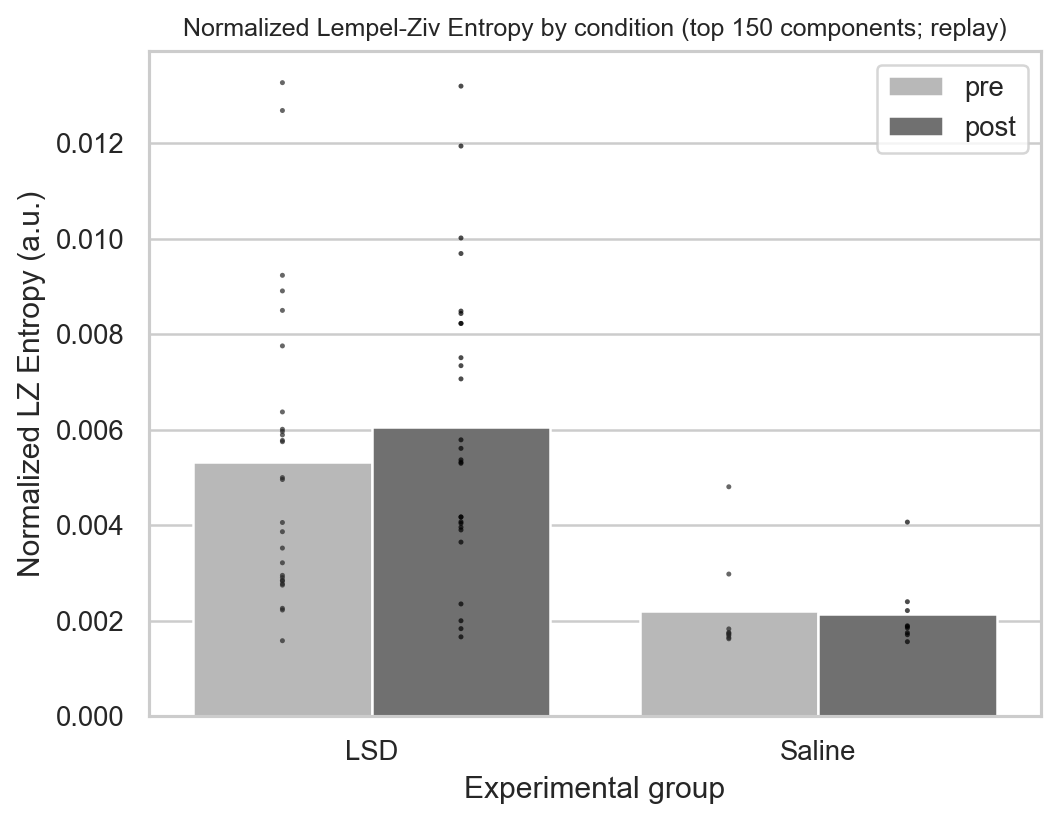

In [202]:
epoch_df = replay_df # <-- target epoch

anova = pg.mixed_anova(
                        dv = 'lz_entropy',
                        within = 'time',
                        between = 'condition',
                        subject = 'eid',
                        data = epoch_df)

print(anova)



gray_blue_palette = ['#b8b8b8', '#707070']  # light and dark gray-blue

ax = sns.barplot(data=epoch_df, x='condition', y='lz_entropy', hue='time', palette=gray_blue_palette, ci = 95, errwidth=0, dodge = True)
ax1 = sns.stripplot(data=epoch_df, x='condition', y='lz_entropy', hue = 'time', color='black', size=2, alpha = 0.7, jitter=False, dodge=True, ax=ax, legend=None)

ax.legend(title = "Administration", title_fontsize = 8, fontsize = 8)
ax1.legend()
plt.title(f'Normalized Lempel-Ziv Entropy by condition (top {k} components; replay)', fontsize = 10)

plt.ylabel('Normalized LZ Entropy (a.u.)')
plt.xlabel("Experimental group")
plt.show()

In [145]:
import statsmodels.formula.api as smf
import statsmodels

model = smf.mixedlm(
            formula= "lz_entropy ~ time * epoch * condition",
            data = all_data,
            groups = 'eid')

result = model.fit()

print(result.summary())

                           Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            lz_entropy
No. Observations:              216                Method:                        REML      
No. Groups:                    36                 Scale:                         0.0000    
Min. group size:               6                  Log-Likelihood:                911.6203  
Max. group size:               6                  Converged:                     Yes       
Mean group size:               6.0                                                         
-------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                         0.005    0.000  9.984 0.000  0.004  0.006
time[T.post]   

c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### individual entropy

In [85]:
eid1 = exp_results['eid'].unique()[0]

pre1, post1 = load_pca_results(exp_results, eid1, epoch_name = 'replay')

_, temp_pre,_= get_eigen(pre1)
_, temp_post,_= get_eigen(pre1)

# n_components x n_frames
temp_pre = temp_pre.T
temp_post = temp_post.T

Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18720, 500)
singular value array has shape  (500,)
Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18720, 500)
singular value array has shape  (500,)
(500, 18720)
(500, 18720)


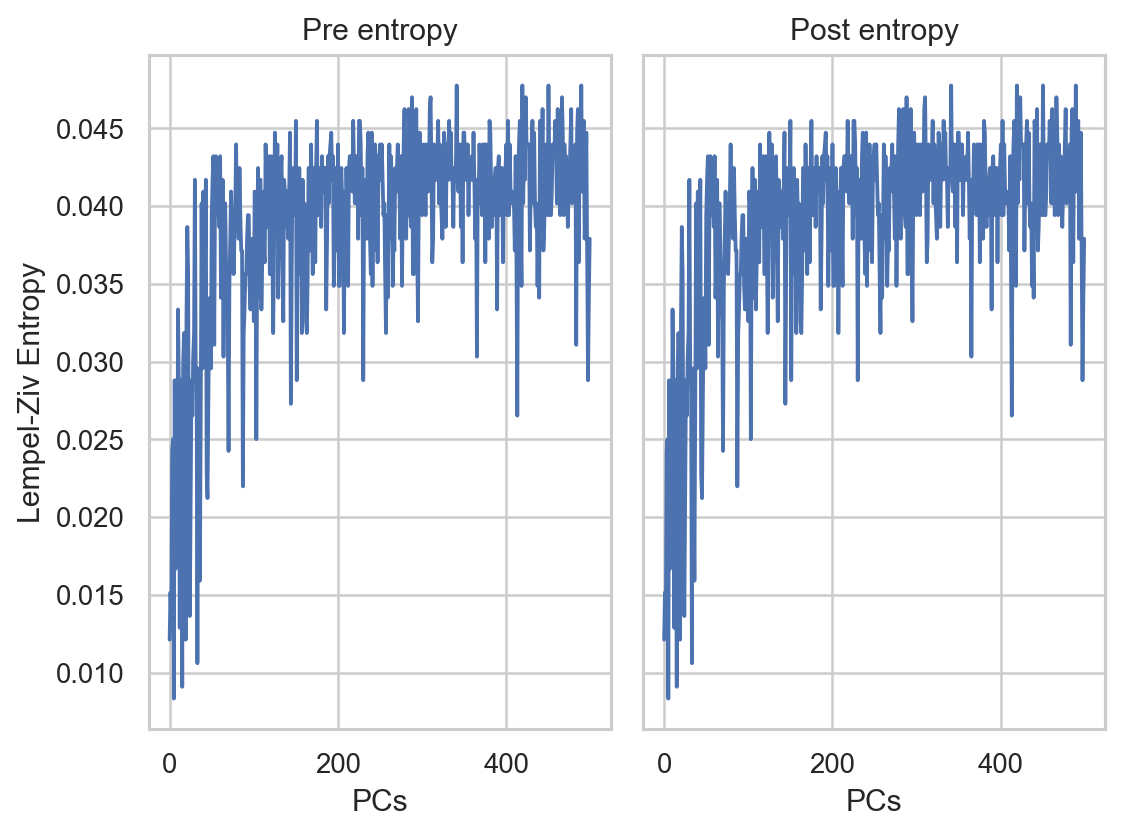

In [ ]:
k = 500
pre_lzentropy = compute_lz_entropy(temp_pre, n_comps=k)
post_lzentropy = compute_lz_entropy(temp_post, n_comps=k)

fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].plot(pre_lzentropy)
axs[0].set_ylabel("Lempel-Ziv Entropy")
axs[0].set_xlabel("PCs")
axs[0].set_title("Pre entropy")
axs[1].set_xlabel("PCs")

axs[1].plot(post_lzentropy)
axs[1].set_title("Post entropy")


plt.tight_layout()
plt.show()

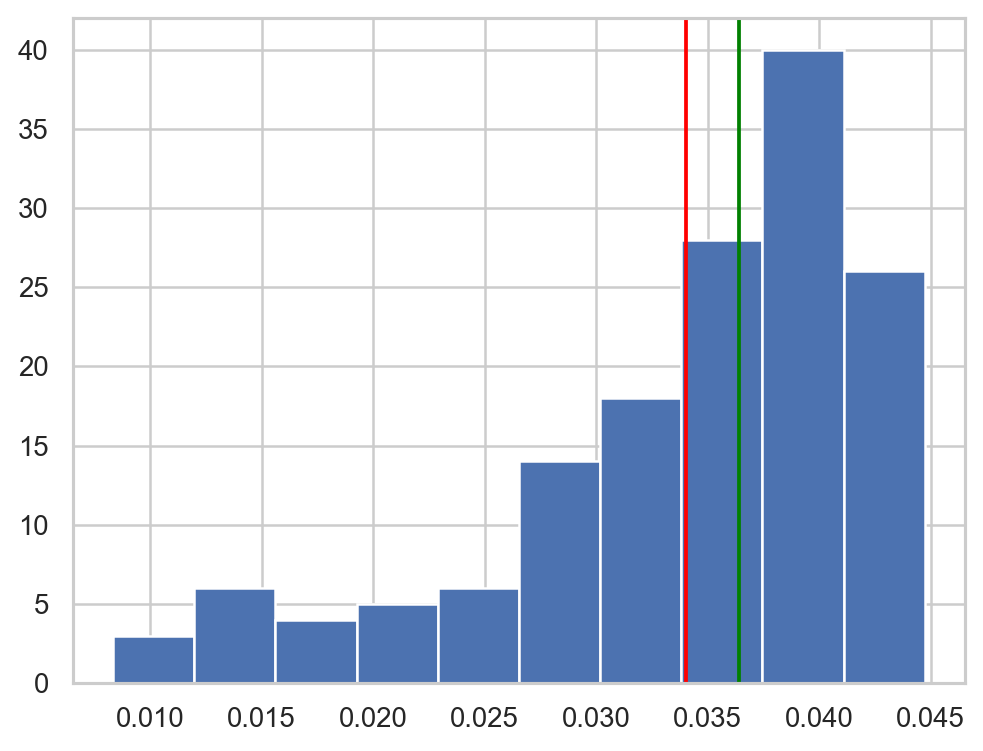

In [127]:
plt.hist(pre_lzentropy)
plt.axvline(np.mean(pre_lzentropy), color = 'red')
plt.axvline(np.median(pre_lzentropy), color = 'green')

# Reduced-Rank Regression: Neuropixel x Behavioral Motif

In [173]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer 
from scipy import stats

from psyfun import io, atlas, spikes, util, plots
from psyfun.config import *

## Spike counts

In [174]:
df_sessions = pd.read_parquet(paths['sessions'])  # session info 
df_sessions = df_sessions.query('n_tasks >= 2').dropna(subset=['task00_spontaneous_start', 'task01_spontaneous_start'])

#Dropping massive outlier from my recordings
#Recording from ZFM-08457 on 2025-03-20
#Notes from recording: No spikes!!! -> SAC! [This recording should probably be removed from the dataset altogether]
df_sessions = df_sessions[df_sessions['eid'] != 'e31bff07-d66c-4a03-894d-f71030161ead']
## If no spikes then it shouldn't survive the merge below?? ##

In [175]:
# Load unit infor for all units
df_units = pd.read_parquet(paths['units'])  # unit info
df_units['coarse_region'] = atlas.coarse_regions(df_units['region'])

In [176]:
# Get eids for sessions with both tasks
eids = df_sessions['eid'].tolist()

# Find good-quality units from those sessions
df_unitquery = df_units.query('eid in @eids and ks2_label == "good"')
# Load spike times for good units
uuids = df_unitquery['uuid']
df_spiketimes = io.load_units(paths['spikes'], uuids)
# Join spike times with unit info
df_spikes = df_unitquery.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_spikes = pd.merge(df_spikes, df_sessions, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns
df_spikes = df_spikes[[col for col in df_spikes.columns if not col.endswith('_x') or col.endswith('_y')]]
# df_spikes['region'] = df_spikes['region'].replace({'none':np.nan})

100%|██████████| 14886/14886 [00:17<00:00, 866.46it/s]


In [179]:
# Define epochs of interest
epochs = [
    'task00_spontaneous', 
    'task00_rfm',
    'task00_replay',
    'task01_spontaneous', 
    'task01_rfm',
    'task01_replay'
]

In [180]:
# Get spike counts for epochs of interest
dt = 1  # get spike counts in 1s bins
for epoch in epochs:
    print(f"Getting spike counts for: {epoch}")
    df_spikes[f'{epoch}_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch=epoch, dt=dt, axis='columns')
    df_spikes[f'{epoch}_rate'] = df_spikes[f'{epoch}_counts'].apply(lambda x: (x / dt).mean())

Getting spike counts for: task00_spontaneous


100%|██████████| 14886/14886 [00:04<00:00, 3125.75it/s]


Getting spike counts for: task00_rfm


100%|██████████| 14886/14886 [00:04<00:00, 3061.16it/s]


Getting spike counts for: task00_replay


100%|██████████| 14886/14886 [00:04<00:00, 3289.96it/s]


Getting spike counts for: task01_spontaneous


100%|██████████| 14886/14886 [00:04<00:00, 3406.04it/s]


Getting spike counts for: task01_rfm


100%|██████████| 14886/14886 [00:04<00:00, 3083.69it/s]


Getting spike counts for: task01_replay


100%|██████████| 14886/14886 [00:06<00:00, 2204.31it/s]


In [185]:
df_spikes

,uuid,depth,channel,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,contamination,contamination_alt,...,task00_rfm_counts,task00_rfm_rate,task00_replay_counts,task00_replay_rate,task01_spontaneous_counts,task01_spontaneous_rate,task01_rfm_counts,task01_rfm_rate,task01_replay_counts,task01_replay_rate
0,05d72810-1b84-4916-8591-df98ed5fad0b,20.0,1,9,0.000071,0.000028,0.000036,1.285330,0.015456,0.014223,...,"[11, 9, 16, 11, 16, 19, 13, 16, 7, 7, 6, 13, 1...",11.182292,"[10, 6, 9, 11, 21, 13, 14, 13, 18, 11, 10, 10,...",11.394231,"[16, 9, 11, 15, 8, 13, 10, 9, 13, 12, 17, 9, 7...",11.200000,"[6, 11, 12, 5, 5, 8, 14, 6, 7, 10, 9, 9, 13, 1...",10.640199,"[17, 16, 15, 10, 9, 15, 6, 8, 9, 11, 10, 4, 11...",10.628205
1,d6a41add-ae82-4c20-872f-f1d058543840,20.0,1,23,0.000071,0.000024,0.000035,1.680850,0.034808,0.032002,...,"[15, 12, 19, 12, 17, 20, 16, 19, 7, 8, 8, 15, ...",12.695312,"[15, 11, 15, 13, 22, 13, 11, 13, 17, 10, 13, 1...",12.612179,"[20, 9, 13, 17, 7, 15, 12, 10, 18, 13, 18, 8, ...",12.440000,"[7, 15, 15, 14, 8, 12, 15, 10, 11, 14, 12, 12,...",12.166253,"[18, 18, 17, 17, 10, 17, 8, 13, 12, 14, 13, 5,...",12.278846
2,5190a146-f3c2-4f33-b38a-5fefcd6919cc,20.0,1,32,0.000060,0.000018,0.000035,1.511594,0.000000,0.000000,...,"[0, 2, 0, 1, 1, 0, 0, 3, 2, 2, 1, 0, 1, 0, 1, ...",0.934896,"[1, 0, 1, 1, 1, 2, 0, 0, 3, 1, 1, 2, 7, 1, 0, ...",1.141026,"[0, 4, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, ...",1.143333,"[2, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 5, 3, 1, ...",1.042184,"[3, 2, 1, 1, 2, 2, 0, 0, 2, 1, 1, 1, 1, 2, 1, ...",1.067308
3,9b9e0a0c-6b81-47ad-b551-03f525e38268,1160.0,115,390,0.000076,0.000027,0.000041,1.521586,0.000000,0.000000,...,"[3, 0, 3, 1, 2, 3, 4, 1, 4, 2, 3, 3, 0, 0, 6, ...",2.309896,"[1, 4, 2, 3, 2, 1, 2, 3, 3, 4, 4, 1, 1, 3, 1, ...",2.419872,"[3, 1, 6, 1, 3, 1, 3, 4, 2, 2, 1, 2, 4, 1, 2, ...",2.590000,"[1, 2, 4, 4, 2, 1, 3, 1, 4, 3, 8, 3, 2, 2, 2, ...",2.491315,"[6, 0, 6, 4, 1, 2, 5, 1, 2, 2, 2, 1, 2, 1, 3, ...",2.628205
4,c2e0ad7f-b5c9-42e8-b536-e06eefb3ecb5,1480.0,147,515,0.000079,0.000027,0.000037,1.349728,0.004387,0.004317,...,"[27, 15, 17, 19, 15, 14, 18, 14, 20, 16, 14, 2...",17.432292,"[23, 23, 23, 20, 20, 10, 19, 20, 19, 18, 19, 1...",18.294872,"[16, 24, 18, 22, 24, 21, 21, 13, 27, 15, 20, 1...",19.766667,"[13, 24, 16, 17, 19, 25, 23, 17, 18, 22, 19, 2...",19.612903,"[12, 22, 21, 23, 21, 22, 26, 26, 22, 24, 21, 1...",19.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14881,4f1c8e7c-d3e6-4a24-bd8d-504acb8ba49b,3040.0,302,851,0.000155,0.000048,0.000068,1.477730,0.053100,0.053738,...,"[3, 1, 0, 0, 1, 0, 0, 0, 1, 5, 4, 3, 1, 3, 6, ...",3.219101,"[4, 6, 5, 2, 2, 5, 2, 3, 3, 2, 2, 1, 0, 3, 2, ...",3.143770,"[7, 0, 6, 3, 2, 5, 5, 1, 3, 2, 7, 8, 1, 2, 2, ...",2.926667,"[1, 3, 2, 2, 3, 1, 6, 1, 3, 0, 0, 1, 3, 0, 0, ...",2.743733,"[0, 4, 3, 3, 2, 3, 3, 1, 5, 0, 1, 4, 1, 0, 1, ...",3.083067
14882,0da64910-6225-4e52-9c04-7dcce4a7d91c,3400.0,338,855,0.000217,0.000042,0.000103,1.394230,0.025030,0.022820,...,"[1, 2, 5, 0, 0, 6, 0, 0, 1, 0, 2, 0, 5, 1, 6, ...",1.811798,"[2, 1, 0, 0, 2, 4, 6, 1, 1, 0, 4, 0, 7, 6, 2, ...",1.696486,"[0, 1, 6, 0, 2, 0, 0, 2, 0, 11, 1, 0, 3, 0, 4,...",2.286667,"[3, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 3, 2, 3, 2, ...",2.144847,"[19, 9, 8, 6, 2, 5, 1, 3, 1, 0, 0, 7, 0, 0, 0,...",1.974441
14883,cf637808-9acc-4ef3-b5a4-77ec9cb496f1,3500.0,349,856,0.000099,0.000023,0.000048,1.779001,0.124494,0.105099,...,"[0, 7, 0, 0, 1, 2, 1, 0, 0, 2, 3, 0, 2, 2, 2, ...",1.764045,"[5, 0, 0, 13, 1, 0, 0, 3, 0, 3, 2, 8, 0, 0, 3,...",1.856230,"[2, 1, 3, 7, 4, 0, 4, 12, 0, 3, 1, 0, 6, 2, 6,...",1.823333,"[5, 0, 0, 1, 0, 1, 2, 0, 0, 5, 4, 2, 0, 0, 4, ...",1.465181,"[6, 2, 1, 4, 0, 2, 2, 2, 3, 1, 1, 0, 0, 1, 4, ...",1.581470
14884,e422ae5e-e311-43a4-ba0d-38676177df63,3500.0,349,857,0.000086,0.000030,0.000046,1.118850,0.000000,0.000000,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.238764,"[0, 0, 1, 2, 1, 0, 0, 2, 1, 1, 1, 3, 0, 0, 0, ...",0.345048,"[0, 0, 0, 0, 0, 0, 0, 1

In [283]:
# Useful metadata for analysis downstream
columns_to_keep = ['subject', 'eid', 'session_n', 'control_recording', 'start_time']

pca_results = []
for idx, session_spikes in df_spikes.groupby('eid'): # add 'region' or any other columns to use for the grouping
    session_data = {col: session_spikes[col].unique()[0] for col in columns_to_keep}
    for epoch in epochs:
        X = np.column_stack(session_spikes[f'{epoch}_counts']) # Puts all spikes into a features x samples matrix
        # transformer = PowerTransformer(method='yeo-johnson', standardize=True) # Pre-processing step to satisfy gaussianity assumption in PCA
        # X_rescaled = transformer.fit_transform(X) 
        pca = PCA()
        X_pcs = pca.fit_transform(X)
        session_data[f'{epoch}_eigenspectrum'] = pca.explained_variance_ratio_
        session_data[f'{epoch}_loadings'] = pca.components_
        session_data[f'{epoch}_projections'] = X_pcs
    pca_results.append(session_data)
df_pca = pd.DataFrame(pca_results)

In [215]:
columns_to_keep = ['subject', 'eid', 'session_n', 'control_recording', 'start_time']

neu_results = []
for idx, session_spikes in df_spikes.groupby('eid'): # add 'region' or any other columns to use for the grouping
    session_data = {col: session_spikes[col].unique()[0] for col in columns_to_keep}
    for epoch in epochs:
        neu_count = np.column_stack(session_spikes[f'{epoch}_counts'])
        session_data[f'{epoch}_neuronmatrix'] = neu_count
    neu_results.append(session_data)
neucounts_df = pd.DataFrame(neu_results)

In [220]:
neuromatrix = neucounts_df['task00_replay_neuronmatrix'][10]

print(neuromatrix.shape)
# neuromatrix shape (n_seconds x n_neurons)

(312, 9)


### Functions

In [289]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score


def reduced_rank_regression(X, Y, rank):
    """
    Perform Reduced Rank Regression (RRR) to predict multivariate Y from X,
    constrained to a linear subspace of dimension `rank`.

    Assumes time alignment between behavioral motifs and neural data.

    Parameters
    -----------
    X : ndarray of shape (n_samples, n_features_X)
        Input data matrix (e.g., neural activity). It has to be (timebins, components).
    
    Y : ndarray of shape (n_features, n_samples)
        Output data matrix (e.g., behavioral projections). Traspose if needed
    
    rank : int
        Desired rank of the regression matrix (number of latent dimensions).

    Returns
    --------
    Y_pred : ndarray of shape (n_samples, n_features_Y)
        Predicted values of Y using the reduced-rank regression model.

    B_rrr : ndarray of shape (n_features_X, n_features_Y)
        Reduced-rank regression coefficient matrix (X @ B_rrr = Y_pred).
    """

    # Centering
    Xc = X - X.mean(axis =0)
    Yc = Y - Y.mean(axis =0)

    # Full-rank regression (least squares)
    B_ols = np.linalg.pinv(Xc) @ Yc  # shape (n_features_X, n_features_Y)

    #  Predict Y using full-rank solution
    Y_hat = Xc @ B_ols  # shape: (n_samples, n_features_Y)

    # SVD of the predicted responses (dissects 'rank' PCs)
    U, S, Vt = np.linalg.svd(Y_hat, full_matrices=False)

    Vt_r = Vt[:rank, :]  # shape: (rank, n_features_Y)

    # Reduced-rank regression matrix
    B_rrr = B_ols @ Vt_r.T @ Vt_r  # shape: (n_features_X, n_features_Y)

    # Predict Y using RRR and re-add the mean (decenter)
    Y_pred = Xc @ B_rrr + Y.mean(axis=0)  # shape: (n_samples, n_features_Y)

    return Y_pred, B_rrr


def cross_validate_rank(X, Y, max_rank=20, n_splits=5, metric='r2', ranks=None):
    """
    Cross-validate Reduced Rank Regression (RRR) to select optimal rank.

    Parameters
    -----------
    X : ndarray (n_samples, n_features_X)
    Y : ndarray (n_samples, n_features_Y)
    
    max_rank : int
        Maximum rank to test. Set to Y.shape[1] otherwise.
    n_splits : int
        Number of folds in K-Fold cross-validation.
    metric : str
        Scoring metric: 'r2' or 'mse'.
    ranks : list or array-like, optional
        Specific ranks to evaluate (overrides max_rank).

    Returns
    --------
    scores : dict
        Average CV score for each rank.
    best_rank : int
        Rank with best score (max R² or min MSE).
    """

    if ranks == 'log' and max_rank >= 20:
        ranks = np.unique(np.logspace(0, np.log10(max_rank), num=10, dtype=int))

    if max_rank < 20 or ranks is None:
            ranks = ranks = np.arange(1, max_rank + 1)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = {}

    for r in ranks:
        fold_scores = []
        for train_idx, test_idx in kf.split(X):
            X_train, Y_train = X[train_idx], Y[train_idx]
            X_test, Y_test = X[test_idx], Y[test_idx]

            # Train RRR on training data
            _, B_rrr= reduced_rank_regression(X_train, Y_train, rank=r)

            # Center X_test to X_train space
            # Predict Y_test using centered X_test and B_rrr
            X_test_c = X_test - X_train.mean(axis=0)
            Y_test_pred = X_test_c @ B_rrr + Y_train.mean(axis=0)

            # Score
            if metric == 'r2':
                score = r2_score(Y_test, Y_test_pred, multioutput='uniform_average')
            elif metric == 'mse':
                score = np.mean((Y_test - Y_test_pred) ** 2)
            else:
                raise ValueError("Unsupported metric: choose 'r2' or 'mse'")

            fold_scores.append(score)

        scores[r] = np.mean(fold_scores)

    best_rank = max(scores, key=scores.get) if metric == 'r2' else min(scores, key=scores.get)
    return scores, best_rank


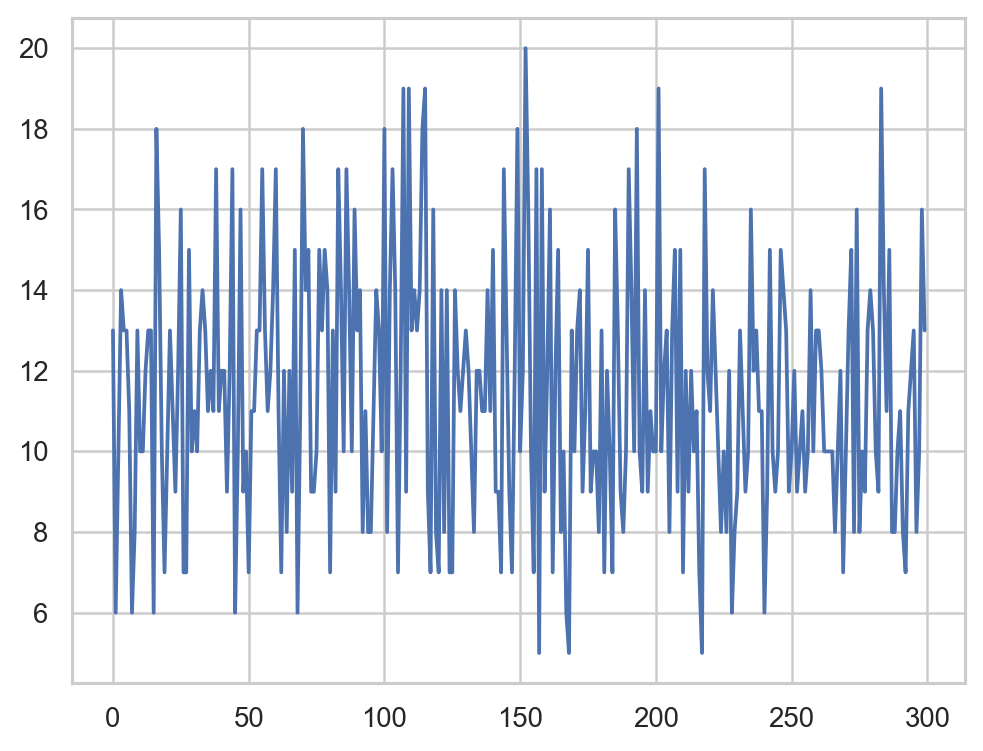

In [190]:
plt.plot(df_spikes['task00_spontaneous_counts'][0])

### Alignment

In [17]:
# let's build the regression for an specific pre replay epoch

eid = exp_results['eid'].unique()[2]

# behavioral data
pre_exp, post_exp = load_pca_results(exp_results, eid, 'spontaneous')
eigmsk, pre_temp, _ = get_eigen(pre_exp) # (n_frames, ncomps)

print(eigmsk.shape)

Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (18000, 500)
singular value array has shape  (500,)
(81920, 500)


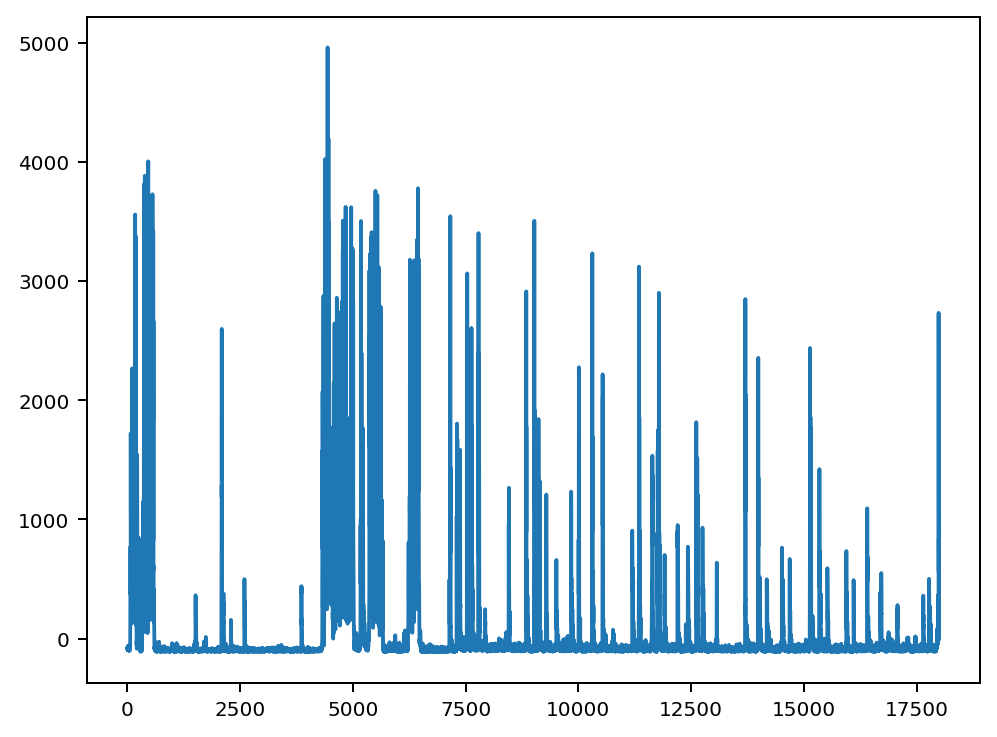

In [18]:
plt.plot(pre_temp[:,0])

In [294]:
# neural data (spike counts)
spike_counts = df_pca['task00_replay_projections'][df_pca['eid'] == eid].values[0]

spike_counts.shape # (n_timebins, n_neurons)

(312, 9)

In [273]:
from scipy.stats import binned_statistic

def align_behavior_neural(projections, spikes):
    """
    Aligns temporal projections (, n_frames) to spike counts (, n_bins).

    Parameters
    ----------
    projections: np.array
        Temporal projections array. Shape must be (n_frames, n_comps)
    spikes: np.array
        Spike counts array. Shape must be (n_neurons, n_bins)

    Returns
    -------
    binned_behavior: np.array
        Temporal projections binned by spike counts. Shape: (n_comps, n_bins)
    
    """
    projections.T # (n_comps, n_frames)
    behavioral_times = np.arange(projections.shape[1]) / 60

    n_bins = spikes.shape[0]
    duration = n_bins  # assuming 1s bins
    bin_edges = np.linspace(0, duration, n_bins + 1)

    binned_behavior = []
    for comp in projections:  # iterate over components
        stat, _, _ = binned_statistic(behavioral_times, comp, statistic='mean', bins=bin_edges)
        binned_behavior.append(stat)

    binned_behavior = np.array(binned_behavior).T  # shape: n_bins × n_comps


    return binned_behavior

In [293]:
# attempt of alignment (2.6)

binned_projection = align_behavior_neural(pre_temp, spike_counts)
print(binned_projection.shape)


(312, 500)


### RRR

In [8]:
plt.plot(pre_temp[0,:])
plt.xlim(0,2000)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [302]:
X = spike_counts
Y = binned_projection

In [300]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(spike_counts, binned_projection)
r2_score(binned_projection, model.predict(spike_counts))

0.02373709731712578

Text(0.5, 1.0, 'Time series')

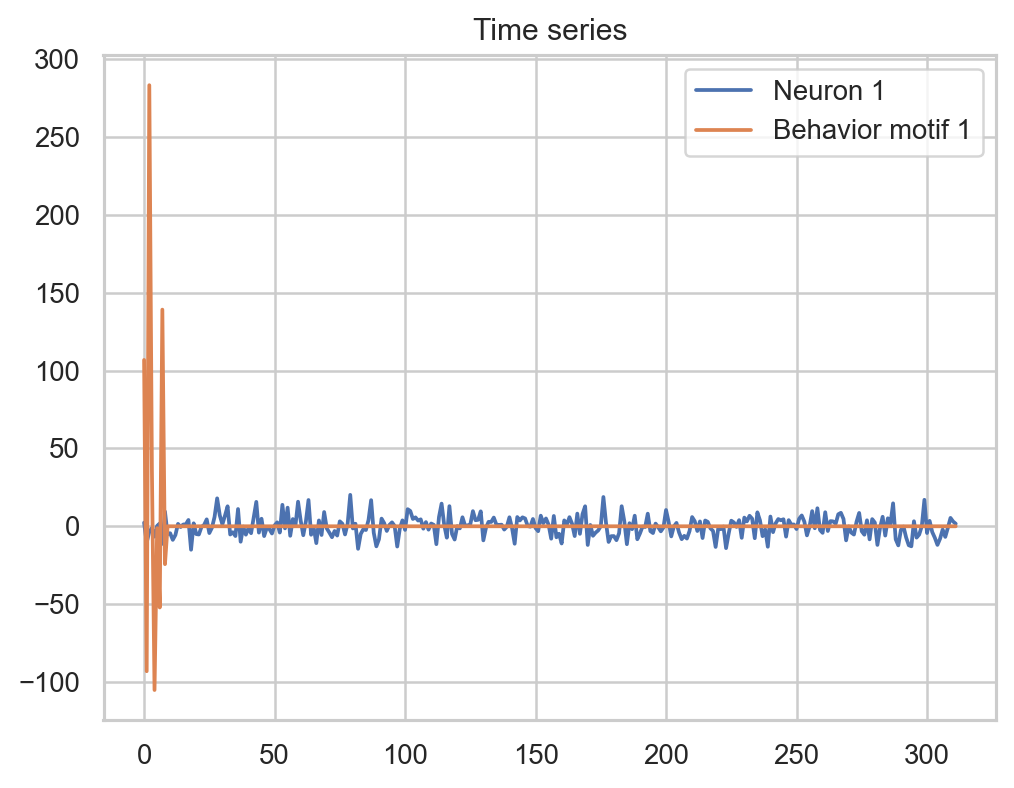

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X[:, 0], label='Neuron 1')
plt.plot(Y[:, 0], label='Behavior motif 1')
plt.legend(); plt.title("Time series")



In [299]:
print(binned_projection.shape)

(312, 500)


In [275]:
pred, Beta = reduced_rank_regression(X = spike_counts, Y = binned_projection, rank = 9)

In [296]:
scores, best = cross_validate_rank(spike_counts, binned_projection, max_rank= 9, n_splits=5, metric = 'mse')

In [297]:
print(scores.items())

dict_items([(1, 3.175349422036639), (2, 3.201581710609907), (3, 3.216113682823655), (4, 3.220880104234368), (5, 3.2217209691733486), (6, 3.223175978408021), (7, 3.2233840698755074), (8, 3.223405243966925), (9, 3.223405243966925)])


 doing spike counts alone is a joke.

### RRR on PCAd spikes

In [12]:
# let's build the regression for an specific pre replay epoch

eid = exp_results['eid'].unique()[0]

# behavioral data
pre_exp, post_exp = load_pca_results(exp_results, eid, 'rfm')
eigmsk, temp_wrong, _ = get_eigen(pre_exp) # (n_frames, ncomps)

print(eigmsk.shape)

Eigenmask matrix has shape  (81920, 500)
Temporal PC matrix has shape (23040, 500)
singular value array has shape  (500,)
(81920, 500)


In [7]:
epoch_pre, _ = get_time_epochs(df_sessions, eid)

_, start, end = epoch_pre[2]


In [8]:
import motionmap as mp

url = one.eid2path(eid)
video_path = os.path.join(url, "raw_video_data", "_iblrig_leftCamera.raw.mp4")
path = [[video_path]]

temp_pre_replay = mp.run_proj(path, start_sec=start, end_sec=end, eigmasks=eigmsk)

Video: 
Computing subsampled mean...
start:  41040  end:  59760
segments  10
Processing temporal projection patch...
U_mot shape (81920, 500)
imall_mot: (999, 81920)
vproj shape (999, 500)
interval start 41040, end 42040, writing to rows 0 to 999
computed video chunk 0 / 19, time  21.90sec
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 42040, end 43040, writing to rows 999 to 1999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 43040, end 44040, writing to rows 1999 to 2999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 44040, end 45040, writing to rows 2999 to 3999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 45040, end 46040, writing to rows 3999 to 4999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 46040, end 47040, writing to rows 4999 to 5999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 47040, end 48040, writing to rows 5999 to 6999
imall_mot: (1000, 81920)
vproj shape (1000, 

In [9]:
temp_pre_replay.shape

(18720, 500)

(0.0, 500.0)

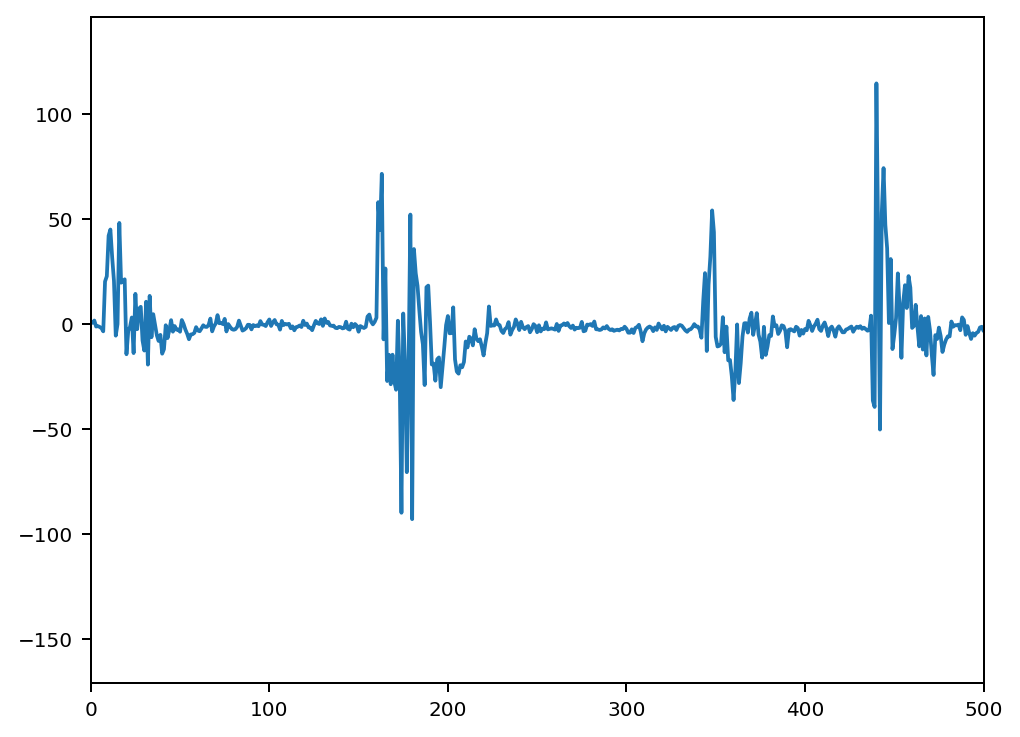

In [17]:
plt.plot(temp_pre_replay[:,300])
plt.xlim(0,500)

## correcting the temporal projections

In [31]:
def expected_path(video_path, start_sec, end_sec):
    """
    Constructs expected path to check if epoch was already processed.
    """
    basename, filename = os.path.split(video_path)
    filename, _ = os.path.splitext(filename)
    epoch_str = f"_start{int(start_sec)}_end{int(end_sec)}"
    expected_save = os.path.join(basename, f"{filename}{epoch_str}_proc.npy")

    return expected_save

In [32]:
import os
import numpy as np
import motionmap
import ibllib.io.video as vidio

results = []  # List to store (eid, epoch, savename)

for eid in eids_cont:
    # Epoch timing 
    epoch_pre, epoch_post = get_time_epochs(df_sessions, eid)

    # Get video path
    url = one.eid2path(eid)
    if not os.path.exists(url):
        video_path = download_video(eid)
    
    video_path = os.path.join(url, "raw_video_data", "_iblrig_leftCamera.raw.mp4")
    path = [[video_path]]
    
    meta = vidio.get_video_meta(video_path)
    fps = meta['fps']

    # --- Pre epochs ---
    for epoch_name, start_sec, end_sec in epoch_pre:
        key = f"{eid}_pre_{epoch_name}"
        expected_save = expected_path(video_path, start_sec, end_sec)
        flag_file = expected_save + ".done"

        if os.path.exists(flag_file):
            print(f"Skipping (already modified): {key}")
            results.append((eid, f'pre_{epoch_name}', expected_save))
            continue

        if not os.path.exists(expected_save):
            print(f"Running motionmap.run for {key}")
            expected_save = motionmap.run(path, sbin=4, start_sec=start_sec, end_sec=end_sec)

        obj = np.load(expected_save, allow_pickle=True).item()
        eigenmsk = np.stack(obj['motMask'][0], axis=0)

        print(f"Recomputing motSVD for {key}")
        motSVD_proj = motionmap.run_proj(path, sbin=4, start_sec=start_sec, end_sec=end_sec, eigmasks=eigenmsk)

        obj["motSVD"] = motSVD_proj
        np.save(expected_save, obj)

        # Mark as completed
        with open(flag_file, "w") as f:
            f.write("done")

        results.append((eid, f'pre_{epoch_name}', expected_save))

    # --- Post epochs ---
    for epoch_name, start_sec, end_sec in epoch_post:
        key = f"{eid}_post_{epoch_name}"
        expected_save = expected_path(video_path, start_sec, end_sec)
        flag_file = expected_save + ".done"

        if os.path.exists(flag_file):
            print(f"Skipping (already modified): {key}")
            results.append((eid, f'post_{epoch_name}', expected_save))
            continue

        if not os.path.exists(expected_save):
            print(f"Running motionmap.run for {key}")
            expected_save = motionmap.run(path, sbin=4, start_sec=start_sec, end_sec=end_sec)

        obj = np.load(expected_save, allow_pickle=True).item()
        eigenmsk = np.stack(obj['motMask'][0], axis=0)

        print(f"Recomputing motSVD for {key}")
        motSVD_proj = motionmap.run_proj(path, sbin=4, start_sec=start_sec, end_sec=end_sec, eigmasks=eigenmsk)

        obj["motSVD"] = motSVD_proj
        np.save(expected_save, obj)

        with open(flag_file, "w") as f:
            f.write("done")

        results.append((eid, f'post_{epoch_name}', expected_save))



c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\one\webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Recomputing motSVD for c7cf8e25-1e2c-4b03-a5f5-5a049f1cd228_pre_task00_spontaneous
Video: 
Computing subsampled mean...
start:  0  end:  18000
segments  10
Processing temporal projection patch...
start frame: 0 to  end frame:  18000
imall_mot: (999, 81920)
vproj shape (999, 500)
interval start 0, end 1000, writing to rows 0 to 999
computed video chunk 0 / 18, time  23.22sec
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 1000, end 2000, writing to rows 999 to 1999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 2000, end 3000, writing to rows 1999 to 2999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 3000, end 4000, writing to rows 2999 to 3999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 4000, end 5000, writing to rows 3999 to 4999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 5000, end 6000, writing to rows 4999 to 5999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 6000, end 7000,

c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\one\webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Recomputing motSVD for 878b86b7-9245-40a3-843e-9ebf0a8251db_pre_task00_spontaneous
Video: 
Computing subsampled mean...
start:  0  end:  18000
segments  10
Processing temporal projection patch...
start frame: 0 to  end frame:  18000
imall_mot: (999, 81920)
vproj shape (999, 500)
interval start 0, end 1000, writing to rows 0 to 999
computed video chunk 0 / 18, time  21.69sec
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 1000, end 2000, writing to rows 999 to 1999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 2000, end 3000, writing to rows 1999 to 2999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 3000, end 4000, writing to rows 2999 to 3999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 4000, end 5000, writing to rows 3999 to 4999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 5000, end 6000, writing to rows 4999 to 5999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 6000, end 7000,

c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\one\webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Recomputing motSVD for 3e9d9490-7fb2-4aa3-b8cd-83f216ad8cde_pre_task00_spontaneous
Video: 
Computing subsampled mean...
start:  0  end:  18000
segments  10
Processing temporal projection patch...
start frame: 0 to  end frame:  18000
imall_mot: (999, 81920)
vproj shape (999, 500)
interval start 0, end 1000, writing to rows 0 to 999
computed video chunk 0 / 18, time  21.90sec
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 1000, end 2000, writing to rows 999 to 1999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 2000, end 3000, writing to rows 1999 to 2999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 3000, end 4000, writing to rows 2999 to 3999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 4000, end 5000, writing to rows 3999 to 4999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 5000, end 6000, writing to rows 4999 to 5999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 6000, end 7000,

c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\one\webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Recomputing motSVD for 55f3644c-3f86-423e-9beb-6604b5aa4e2c_pre_task00_spontaneous
Video: 
Computing subsampled mean...
start:  0  end:  18000
segments  10
Processing temporal projection patch...
start frame: 0 to  end frame:  18000
imall_mot: (999, 81920)
vproj shape (999, 500)
interval start 0, end 1000, writing to rows 0 to 999
computed video chunk 0 / 18, time  22.04sec
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 1000, end 2000, writing to rows 999 to 1999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 2000, end 3000, writing to rows 1999 to 2999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 3000, end 4000, writing to rows 2999 to 3999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 4000, end 5000, writing to rows 3999 to 4999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 5000, end 6000, writing to rows 4999 to 5999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 6000, end 7000,

c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\one\webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Recomputing motSVD for e8128c55-b322-438a-9498-edd47ae4b794_pre_task00_spontaneous
Video: 
Computing subsampled mean...
start:  0  end:  18000
segments  10
Processing temporal projection patch...
start frame: 0 to  end frame:  18000
imall_mot: (999, 81920)
vproj shape (999, 500)
interval start 0, end 1000, writing to rows 0 to 999
computed video chunk 0 / 18, time  22.17sec
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 1000, end 2000, writing to rows 999 to 1999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 2000, end 3000, writing to rows 1999 to 2999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 3000, end 4000, writing to rows 2999 to 3999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 4000, end 5000, writing to rows 3999 to 4999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 5000, end 6000, writing to rows 4999 to 5999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 6000, end 7000,

c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\one\webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Recomputing motSVD for 5c28961e-1183-43f9-86a8-9c1c9d8ed743_pre_task00_spontaneous
Video: 
Computing subsampled mean...
start:  0  end:  18000
segments  10
Processing temporal projection patch...
start frame: 0 to  end frame:  18000
imall_mot: (999, 81920)
vproj shape (999, 500)
interval start 0, end 1000, writing to rows 0 to 999
computed video chunk 0 / 18, time  22.34sec
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 1000, end 2000, writing to rows 999 to 1999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 2000, end 3000, writing to rows 1999 to 2999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 3000, end 4000, writing to rows 2999 to 3999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 4000, end 5000, writing to rows 3999 to 4999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 5000, end 6000, writing to rows 4999 to 5999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 6000, end 7000,

c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\one\webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Recomputing motSVD for bb0e0ad2-4c98-4c98-b92f-559683e8a6f3_pre_task00_spontaneous
Video: 
Computing subsampled mean...
start:  0  end:  18000
segments  10
Processing temporal projection patch...
start frame: 0 to  end frame:  18000
imall_mot: (999, 81920)
vproj shape (999, 500)
interval start 0, end 1000, writing to rows 0 to 999
computed video chunk 0 / 18, time  22.27sec
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 1000, end 2000, writing to rows 999 to 1999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 2000, end 3000, writing to rows 1999 to 2999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 3000, end 4000, writing to rows 2999 to 3999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 4000, end 5000, writing to rows 3999 to 4999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 5000, end 6000, writing to rows 4999 to 5999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 6000, end 7000,

c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\one\webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Recomputing motSVD for 58c61f29-d4e6-4ca7-b6de-bd860e83fe4e_pre_task00_spontaneous
Video: 
Computing subsampled mean...
start:  0  end:  18000
segments  10
Processing temporal projection patch...
start frame: 0 to  end frame:  18000
imall_mot: (999, 81920)
vproj shape (999, 500)
interval start 0, end 1000, writing to rows 0 to 999
computed video chunk 0 / 18, time  22.27sec
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 1000, end 2000, writing to rows 999 to 1999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 2000, end 3000, writing to rows 1999 to 2999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 3000, end 4000, writing to rows 2999 to 3999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 4000, end 5000, writing to rows 3999 to 4999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 5000, end 6000, writing to rows 4999 to 5999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 6000, end 7000,

c:\Users\marti\anaconda3\envs\iblenv\lib\site-packages\one\webclient.py:144: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Recomputing motSVD for cdc1965e-4324-422a-a9d4-86b4e5d0de92_pre_task00_spontaneous
Video: 
Computing subsampled mean...
start:  0  end:  18000
segments  10
Processing temporal projection patch...
start frame: 0 to  end frame:  18000
imall_mot: (999, 81920)
vproj shape (999, 500)
interval start 0, end 1000, writing to rows 0 to 999
computed video chunk 0 / 18, time  22.15sec
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 1000, end 2000, writing to rows 999 to 1999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 2000, end 3000, writing to rows 1999 to 2999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 3000, end 4000, writing to rows 2999 to 3999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 4000, end 5000, writing to rows 3999 to 4999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 5000, end 6000, writing to rows 4999 to 5999
imall_mot: (1000, 81920)
vproj shape (1000, 500)
interval start 6000, end 7000,

In [33]:
epoch_df = rfm_df # <-- target epoch

anova = pg.mixed_anova(
                        dv = 'pow_law',
                        within = 'epoch', # change back to 'time'
                        between = 'condition',
                        subject = 'eid',
                        data = all_data)

print(anova)



gray_blue_palette = ['#b8b8b8', '#707070']  # light and dark gray-blue

ax = sns.barplot(data=all_data, x='epoch', y='pow_law', hue='condition', palette=gray_blue_palette, ci = 95, errwidth=0, dodge = True)
ax1 = sns.stripplot(data=all_data, x='epoch', y='pow_law', hue = 'condition', color='black', size=2, alpha = 0.7, jitter=True, dodge=True, ax=ax, legend=None)

ax.legend(title = "Administration", title_fontsize = 8, fontsize = 8)
ax1.legend()
plt.title(f'Power Law Slope Change by Epoch (top {k} components)', fontsize = 10)

plt.ylabel('Power law slope (a.u.)')
plt.xlabel("Experimental group")
plt.show()

NameError: name 'rfm_df' is not defined

In [ ]:


eidx = load_pca_results(exp_results, )